# Assignment 3: Classification of image data with multilayer perceptrons and convolutional neural networks

Let us start with some installations and imports.

In [ ]:
%pip install medmnist  # Install the medmnist package to access the dataset

In [32]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import torch
import torchvision.transforms as T
from matplotlib.ticker import MaxNLocator
from medmnist import OrganAMNIST
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
from time import time

%matplotlib inline
plt.rc('axes', axisbelow=True)
plt.style.use(['seaborn-v0_8', 'seaborn-v0_8-whitegrid'])

## Task 1: Acquire the data

Before working with the data, we will perform some preprocessing to the images, allowing for pixel-normalization and flattening/vectorization. Note, to avoid data leakage, we will use the mean and standard deviation of the training dataset to perform normalization.

In [104]:
# Get the mean and standard deviation of the dataset
train_loader = DataLoader(
  OrganAMNIST(root='./data', split='train', transform=T.Compose([T.ToTensor(), T.Lambda(torch.flatten)]), download=True),
  batch_size=2048
)

total = 0
sq_total = 0
N = 0

for data, _ in train_loader:
  total += data.sum()
  sq_total += (data ** 2).sum()
  N += data.numel()

mean, std =  (total / N).item(), (((sq_total / N) - (total / N) ** 2) ** 0.5).item()

transform = T.Compose([
  T.ToTensor(),
  T.Normalize((mean,), (std,)),
  T.Lambda(torch.flatten),
])

# Load the datasets
train = OrganAMNIST(root='./data', split='train', transform=transform, download=True)
test = OrganAMNIST(root='./data', split='test', transform=transform, download=True)
val = OrganAMNIST(root='./data', split='val', transform=transform, download=True)

# Constants
NUM_CLASSES = 11
CLASS_LABELS = [
  "bladder", "femur-left", "femur-right", "heart", "kidney-left", "kidney-right",
  "liver", "lung-left", "lung-right", "pancreas", "spleen"
]

Using downloaded and verified file: ./data/organamnist.npz
Using downloaded and verified file: ./data/organamnist.npz
Using downloaded and verified file: ./data/organamnist.npz
Using downloaded and verified file: ./data/organamnist.npz


Let us explore the data a bit to get a better understanding. Let us first see the shapes of the datasets.

In [3]:
total = len(train) + len(test) + len(val)
total, len(train) / total, len(test) / total, len(val) / total, train.imgs[0].shape

(58830, 0.5874723780384158, 0.3021927587965324, 0.11033486316505184, (28, 28))

So, we see there are about 60,000 samples in the entire dataset, with about a 60-10-30 split between the training, validation, and test splits. The images themselves are grayscale 28px by 28px (784-vector), just as the regular MNIST dataset. Let us take a look at some sample images from each class.

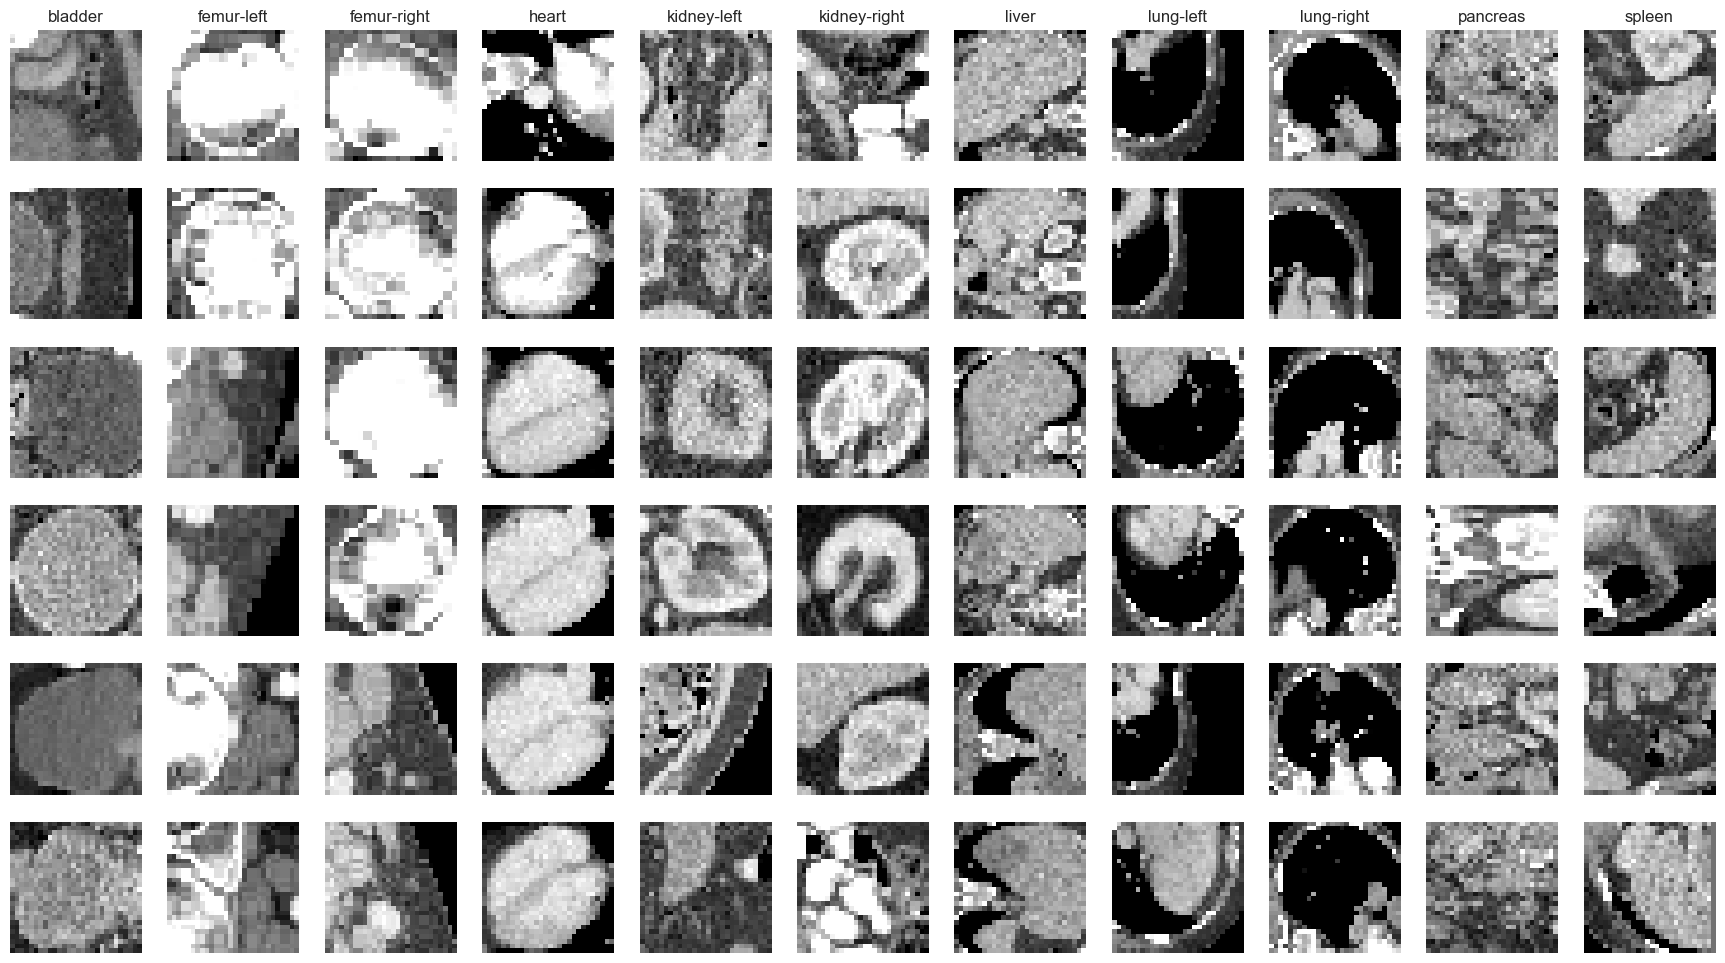

In [5]:
# Sample images from each class in the training set
fig, axs = plt.subplots(6, NUM_CLASSES, figsize=(22, 12))

for i in range(NUM_CLASSES):
  class_data = train.imgs[train.labels.flatten() == i]

  for j in range(6):
    idx = np.random.randint(class_data.shape[0])
    img = class_data[idx]
    axs[j, i].imshow(img, cmap='gray')
    axs[j, i].axis('off')

    if j == 0:
      axs[j, i].set_title(CLASS_LABELS[i])

We see there is quite a lot of diversity within each class (e.g., lots of variation), making this classification task quite a bit more difficult than classifying digits. Now, let us take a look at the class distributions.

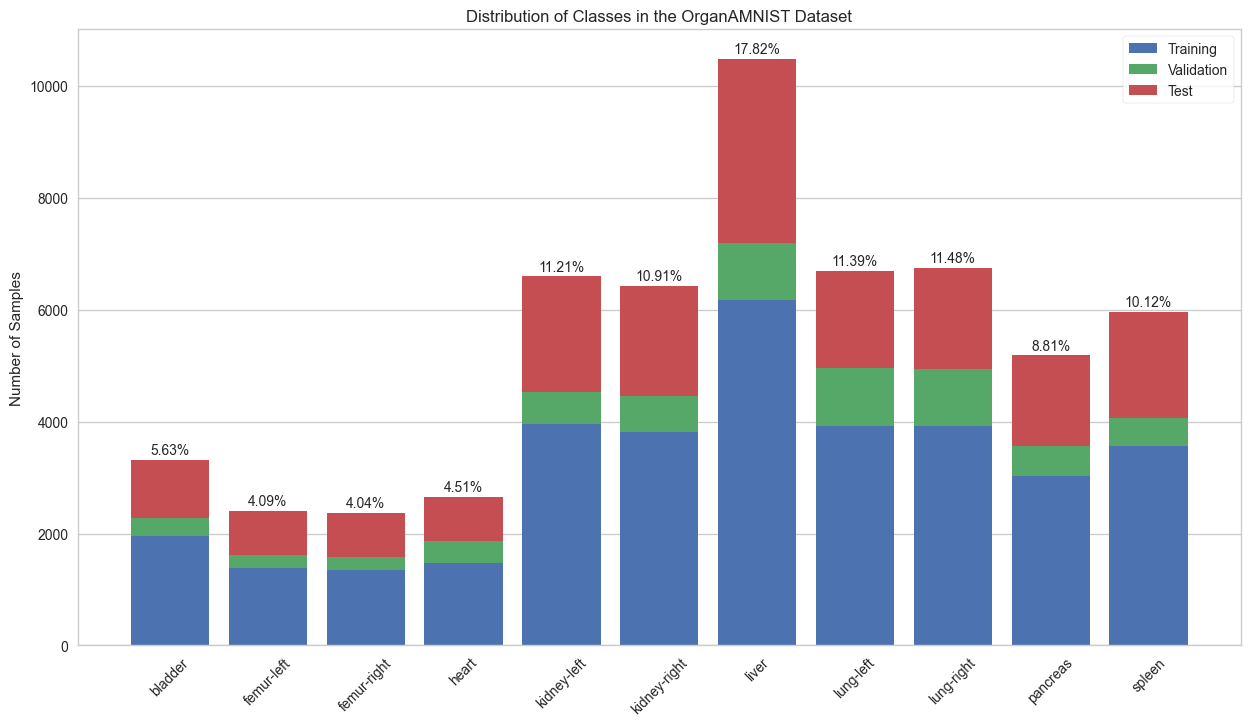

In [6]:
train_distribution = [0] * NUM_CLASSES
val_distribution = [0] * NUM_CLASSES
test_distribution = [0] * NUM_CLASSES

for _, y in train:
  train_distribution[y.item()] += 1

for _, y in val:
  val_distribution[y.item()] += 1

for _, y in test:
  test_distribution[y.item()] += 1

bottom = np.zeros(NUM_CLASSES)

plt.figure(figsize=(15, 8))
plt.xticks(range(NUM_CLASSES), CLASS_LABELS, rotation=45)

for label, distribution in [("Training", train_distribution), ("Validation", val_distribution), ("Test", test_distribution)]:
  plt.bar(range(NUM_CLASSES), distribution, bottom=bottom, label=label)
  bottom += distribution

for i in range(NUM_CLASSES):
  plt.text(i, bottom[i] + 300, f"{bottom[i] / (len(train) + len(val) + len(test)):.2%}", ha='center', va='top')

plt.title("Distribution of Classes in the OrganAMNIST Dataset")
plt.ylabel("Number of Samples")
plt.grid(axis='x')
plt.legend(frameon=True)
plt.savefig("1.png", dpi=600, bbox_inches='tight')

We see there are fewer samples of bladder, femur, and heart imaging, whereas the liver imaging seems to be quite high! The distribution among the remaining classes seems to be well-balanced. This under-representation may lead to lower performance on the first 4 classes.

## Task 2: Implement a multilayer perceptron
Before diving into implementation, let us define a quick helper function for loading sampler from the dataset. This should avoid us interchanging numpy arrays and pytorch tensors.

In [3]:
def loader(x, y, batch_size):
  idxs = np.random.permutation(len(x))
  x = x[idxs]
  y = y[idxs]

  for i in range(0, len(x), batch_size):
    yield x[i:i + batch_size], y[i:i + batch_size]

Now, let us define our activation functions and their derivatives (to be used for backpropagation). Note that the the softmax derivative has not been included as it will only every be used as the final layer.

In [4]:
class Activations:
  @staticmethod
  def relu(x):
    return np.maximum(x, 0)

  @staticmethod
  def relu_derivative(x):
    return np.where(x > 0, 1, 0)

  @staticmethod
  def leaky_relu(x):
    return np.maximum(x, 0) + 0.01 * np.minimum(x, 0)

  @staticmethod
  def leaky_relu_derivative(x):
    return np.where(x > 0, 1, 0.01)

  @staticmethod
  def sigmoid(x):
    return 1 / (1 + np.exp(-x))

  @staticmethod
  def sigmoid_derivative(x):
    return x * (1 - x)

  @staticmethod
  def tanh(x):
    return np.tanh(x)

  @staticmethod
  def tanh_derivative(x):
    return 1 - x ** 2

  @staticmethod
  def softmax(x):
    z = np.exp(x - np.max(x, axis=1, keepdims=True))
    return z / np.sum(z, axis=1, keepdims=True)

  @staticmethod
  def get(activation):
    return getattr(Activations, activation)

  @staticmethod
  def get_derivative(activation):
    return getattr(Activations, f'{activation}_derivative')

Now, let us finally implement the MLP, which consists of two classes: The individual layers, and the overall neural network.

In [5]:
class Layer:
  def __init__(self, prev_units, nunits, activation, prev_activation, l1: float = 0, l2: float = 0):
    self.activation = Activations.get(activation)
    self.derivative = Activations.get_derivative(prev_activation)

    self.previous = None
    self.weights = np.random.standard_normal((prev_units, nunits)) / np.sqrt(prev_units)
    self.l1 = l1
    self.l2 = l2

  def forward(self, x):
    x = np.hstack([x, np.ones((x.shape[0], 1))])
    self.previous = x
    return self.activation(x @ self.weights)

  def backward(self, target, alpha):
    dw = self.previous.T @ target + self.l1 * np.sign(self.weights) + self.l2 * self.weights
    target = (target @ self.weights[:-1].T) * self.derivative(self.previous[:, :-1])
    self.weights -= alpha * dw
    return target


class MultiLayerPerceptron:
  def __init__(self, activation: str, dims: list[int], b: int = 256, epochs: int = 10, alpha: float = 0.001, l1: float = 0, l2: float = 0, history: bool = False):
    self.dims = dims
    self.layers = [
      Layer(dims[i] + 1, dims[i + 1], activation, activation, l1=l1, l2=l2) for i in range(len(dims) - 2)
    ]
    self.layers.append(Layer(dims[-2] + 1, dims[-1], 'softmax', activation, l1=l1, l2=l2))  # Output layer

    self.b = b
    self.epochs = epochs
    self.alpha = alpha
    self.history = history

    if history:
      self.record = {'train': [], 'test': []}

  def fit(self, x, y, x_test=None, y_test=None):
    if x.shape[1] != self.dims[0]:
      raise ValueError('Input dimensions do not match the model')

    y_orig = y

    y = np.eye(self.dims[-1])[y]

    for _ in range(self.epochs):
      for x_batch, y_batch in loader(x, y, self.b):
        yh = self.forward(x_batch)
        self.backward(y_batch, yh)

      if self.history:
          self.record['train'].append(self.evaluate_acc(y_orig, self.predict(x))[0])
          self.record['test'].append(self.evaluate_acc(y_test, self.predict(x_test))[0])

  def forward(self, x):
    for layer in self.layers:
      x = layer.forward(x)
    return x

  def backward(self, y, yh):
    target = yh - y

    for layer in reversed(self.layers):
      target = layer.backward(target, self.alpha)

  def predict(self, x):
    return self.forward(x)

  def cost(self, y, yh):
    y = np.eye(self.dims[-1])[y]
    return -np.sum(y * np.log(yh), axis=1).mean()

  def evaluate_acc(self, y, yh):
    preds = np.argmax(yh, axis=1)
    accuracy = (preds == y).mean()
    class_accuracies = [(preds[y == i] == i).mean() for i in range(self.dims[-1])]
    return accuracy, class_accuracies

Let us also define a conveniece grid-search method to allow us to determine our optimal hyper parameters.

In [ ]:
def grid_search(
    x: np.ndarray, y: np.ndarray, x_val: np.ndarray, y_val: np.ndarray,
    grid: list, model_supplier, evaluator
  ):
  scores = []

  for _ in range(10):
    iter_scores = []

    for params in grid:
      print(f'Training model with: {params}', end=' ' * 50 + '\r')
      model = model_supplier(params)
      model.fit(x, y)

      iter_scores.append(evaluator(model, y_val, model.predict(x_val)))

    scores.append(iter_scores)

  return np.mean(scores, axis=0)

## Task 3: Running experiments
Let us first transform our dataset into what is expected by our model's interface.


In [106]:
x_train, y_train = np.array([x for x, _ in train]), np.array([y.item() for _, y in train])
x_val, y_val = np.array([x for x, _ in val]), np.array([y.item() for _, y in val])
x_test, y_test = np.array([x for x, _ in test]), np.array([y.item() for _, y in test])

### 3.1 Various network architectures with ReLU activation
We can perform a search over various learning rates to find the optimal, and use it to run our training experiment. As such, our three architectures can be trained and evaluated as follows.

Model: No hidden layers01                                                    
Training accuracy: 83.07%
Test accuracy: 59.94%
bladder: 28.28%
femur-left: 55.99%
femur-right: 53.47%
heart: 65.48%
kidney-left: 43.22%
kidney-right: 42.19%
liver: 80.46%
lung-left: 89.70%
lung-right: 89.41%
pancreas: 42.48%
spleen: 39.54%



/var/folders/j9/t7lmvw5n2knf_2684z7x78ph0000gn/T/ipykernel_91008/4016110910.py:36: RuntimeWarning: overflow encountered in subtract
  z = np.exp(x - np.max(x, axis=1, keepdims=True))
/var/folders/j9/t7lmvw5n2knf_2684z7x78ph0000gn/T/ipykernel_91008/4016110910.py:36: RuntimeWarning: invalid value encountered in subtract
  z = np.exp(x - np.max(x, axis=1, keepdims=True))


Model: Single ReLU hidden layer                                            
Training accuracy: 99.96%
Test accuracy: 72.53%
bladder: 69.02%
femur-left: 68.62%
femur-right: 76.17%
heart: 61.78%
kidney-left: 56.06%
kidney-right: 62.95%
liver: 88.10%
lung-left: 90.44%
lung-right: 89.24%
pancreas: 61.41%
spleen: 56.85%

Model: Two ReLU hidden layers                                                
Training accuracy: 100.00%
Test accuracy: 74.14%
bladder: 66.12%
femur-left: 72.19%
femur-right: 82.47%
heart: 67.26%
kidney-left: 59.40%
kidney-right: 64.07%
liver: 89.47%
lung-left: 91.93%
lung-right: 89.02%
pancreas: 62.95%
spleen: 57.43%



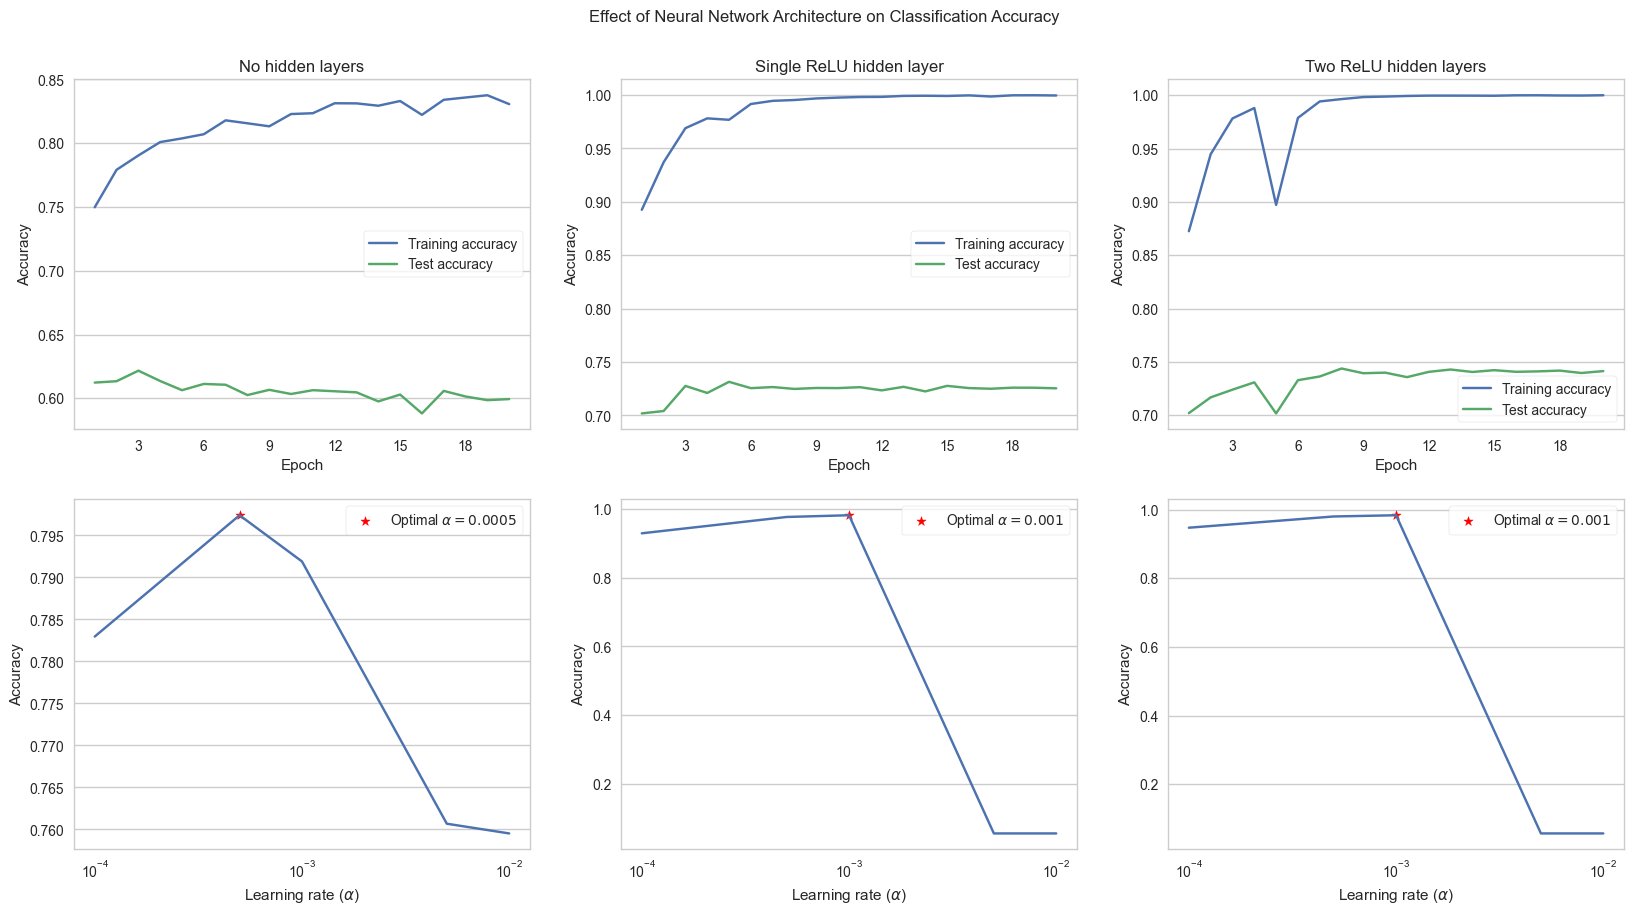

In [136]:
alpha = [0.0001, 0.0005, 0.001, 0.005, 0.01]
activation = 'relu'
epochs = 20
architectures = [
  ("No hidden layers", [x_train.shape[1], NUM_CLASSES]),
  ("Single ReLU hidden layer", [x_train.shape[1], 256, NUM_CLASSES]),
  ("Two ReLU hidden layers", [x_train.shape[1], 256, 256, NUM_CLASSES]),
]

fig, axes = plt.subplots(2, len(architectures), figsize=(20, 10))

for i, (name, arch) in enumerate(architectures):
  accuracies = grid_search(
    x_train, y_train, x_val, y_val,
    alpha,
    lambda a: MultiLayerPerceptron(activation, arch, epochs=20, alpha=a),
    lambda model, y, yh: model.evaluate_acc(y, yh)[0]
  )

  opt = alpha[np.argmax(accuracies)]
  axes[1][i].plot(alpha, accuracies)
  axes[1][i].scatter(opt, np.max(accuracies), color='red', marker='*', label=f'Optimal $\\alpha = {opt}$')
  axes[1][i].set_ylabel('Accuracy')
  axes[1][i].set_xlabel('Learning rate ($\\alpha$)')
  axes[1][i].set_xscale('log')
  axes[1][i].grid(axis='x')
  axes[1][i].legend(frameon=True)

  model = MultiLayerPerceptron(activation, arch, epochs=epochs, alpha=opt, history=True)
  model.fit(x_train, y_train, x_test=x_test, y_test=y_test)

  train_acc, _ = model.evaluate_acc(y_train, model.predict(x_train))
  test_acc, class_acc = model.evaluate_acc(y_test, model.predict(x_test))

  axes[0][i].plot(range(1, epochs + 1), model.record['train'], label='Training accuracy')
  axes[0][i].plot(range(1, epochs + 1), model.record['test'], label='Test accuracy')
  axes[0][i].set_ylabel('Accuracy')
  axes[0][i].set_xlabel('Epoch')
  axes[0][i].grid(axis='x')
  axes[0][i].xaxis.set_major_locator(MaxNLocator(integer=True))
  axes[0][i].legend(frameon=True)
  axes[0][i].set_title(name)

  print(f'Model: {name}')
  print(f'Training accuracy: {train_acc:.2%}')
  print(f'Test accuracy: {test_acc:.2%}')

  for i, acc in enumerate(class_acc):
    print(f'{CLASS_LABELS[i]}: {acc:.2%}')

  print()

fig.suptitle("Effect of Neural Network Architecture on Classification Accuracy", y=0.95)
fig.savefig("3.1.png", dpi=600, bbox_inches='tight')

For the case where our network has no hidden layers, we notice that the performance on the test set is quite low, at about 59.9%. Similarly, the training accuracy is around 83.1%. The introduction of non-linearity and the hidden layer leads to a significant improvement in the performance on the train and test sets, rising to 100% and 72.5%, respectively, for the single hidden layer network. By adding another layer, we see that our network is able to learn at a higher level of abstraction, leading to a slight increase in test performance (74.1%) and 100% train accuracy. Although slight, it is interesting to note that the network with two hidden layers seems to converge to 100% on the training set just a bit earlier than the network with a single layer, indicating that there may be some degree of overfitting occurring.

### 3.2 Exploring `tanh` and Leaky-ReLU activations

We can repeat our procedure from the previous section, simply replacing the activation function being used. As defined earlier, we will use Leaky-ReLU with a gradient parameter of 0.01.

/var/folders/j9/t7lmvw5n2knf_2684z7x78ph0000gn/T/ipykernel_66403/4016110910.py:36: RuntimeWarning: invalid value encountered in subtract
  z = np.exp(x - np.max(x, axis=1, keepdims=True))


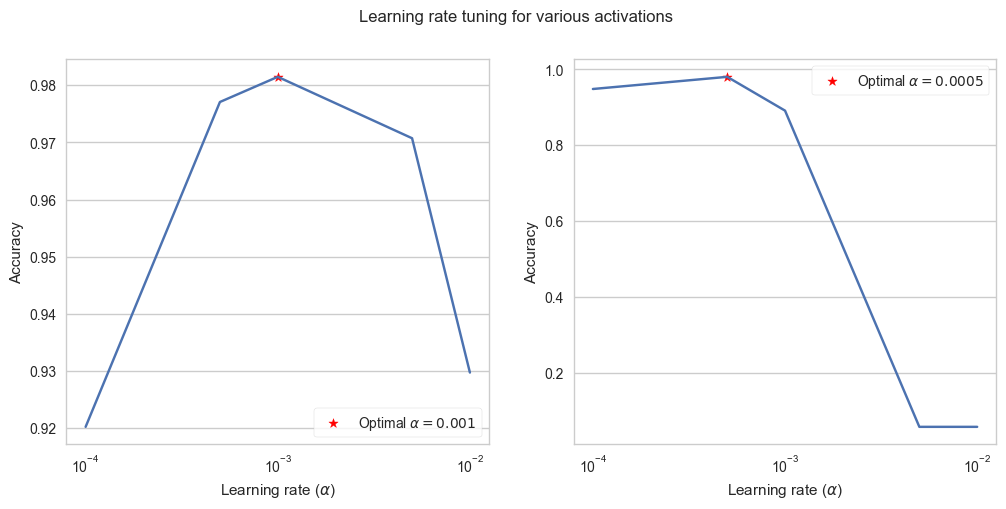

In [34]:
alpha = [0.0001, 0.0005, 0.001, 0.005, 0.01]
arch = [x_train.shape[1], 256, 256, NUM_CLASSES]
epochs = 20
activations = [
  ("$\\tanh$ activation", 'tanh'),
  ("Leaky-ReLU activation", 'leaky_relu'),
]

fig, axes = plt.subplots(1, len(activations), figsize=(12, 5))

opts = []

for i, (name, activation) in enumerate(activations):
  accuracies = grid_search(
    x_train, y_train, x_val, y_val,
    alpha,
    lambda a: MultiLayerPerceptron(activation, arch, epochs=20, alpha=a),
    lambda model, y, yh: model.evaluate_acc(y, yh)[0]
  )

  opt = alpha[np.argmax(accuracies)]
  axes[i].plot(alpha, accuracies)
  axes[i].scatter(opt, np.max(accuracies), color='red', marker='*', label=f'Optimal $\\alpha = {opt}$')
  axes[i].set_ylabel('Accuracy')
  axes[i].set_xlabel('Learning rate ($\\alpha$)')
  axes[i].set_xscale('log')
  axes[i].grid(axis='x')
  axes[i].legend(frameon=True)

  opts.append(opt)

fig.suptitle("Learning rate tuning for various activations", y=0.98)
fig.savefig("3.2-loss.png", dpi=600, bbox_inches='tight')

Model: $\tanh$ activation
Training accuracy: 100.00%
Test accuracy: 71.54%

Model: Leaky-ReLU activation
Training accuracy: 99.97%
Test accuracy: 74.38%



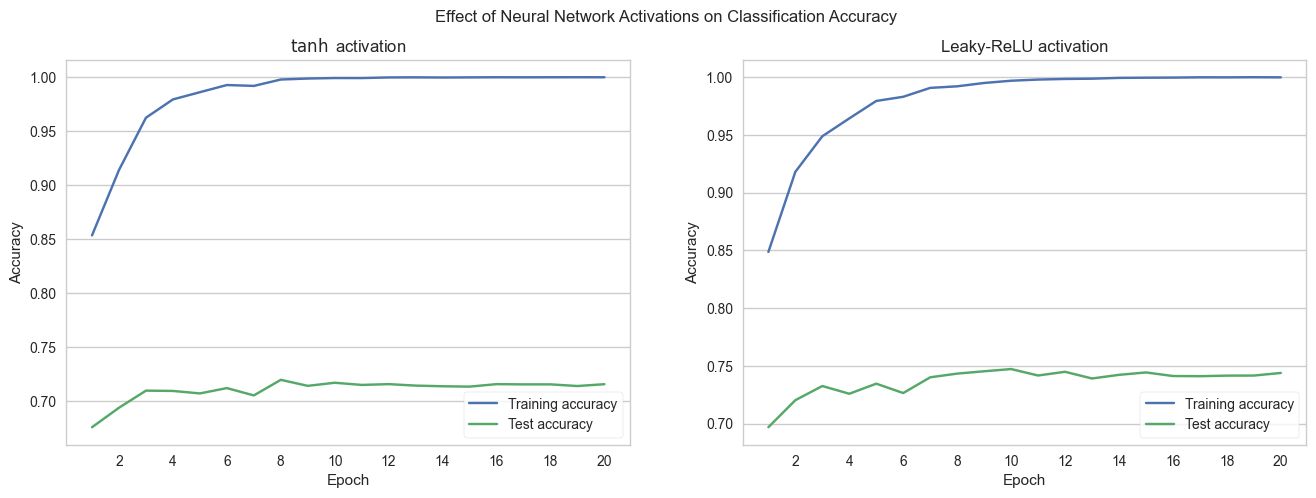

In [39]:
fig, axes = plt.subplots(1, len(activations), figsize=(16, 5))

for i, (name, activation) in enumerate(activations):
  model = MultiLayerPerceptron(activation, arch, epochs=epochs, alpha=opts[i], history=True)
  model.fit(x_train, y_train, x_test=x_test, y_test=y_test)

  train_acc, _ = model.evaluate_acc(y_train, model.predict(x_train))
  test_acc, _ = model.evaluate_acc(y_test, model.predict(x_test))

  axes[i].plot(range(1, epochs + 1), model.record['train'], label='Training accuracy')
  axes[i].plot(range(1, epochs + 1), model.record['test'], label='Test accuracy')
  axes[i].xaxis.set_major_locator(MaxNLocator(integer=True, nbins=11))
  axes[i].set_ylabel('Accuracy')
  axes[i].set_xlabel('Epoch')
  axes[i].grid(axis='x')
  axes[i].legend(frameon=True)
  axes[i].set_title(name)

  print(f'Model: {name}')
  print(f'Training accuracy: {train_acc:.2%}')
  print(f'Test accuracy: {test_acc:.2%}')

  print()

fig.suptitle("Effect of Neural Network Activations on Classification Accuracy", y=0.98)
fig.savefig("3.2.png", dpi=600, bbox_inches='tight')

For the `tanh` activation, we see that the convergence of the model training is even faster (converging to 100% training accuracy after 7 epochs), however, the test performance seems to have taken a hit, falling lower than the single hidden layer case for ReLU activation. The Leaky ReLU model seems to perform a bit better when compared regular ReLU case (looking at accuracies over the epochs), indicating the removal of the zero gradient leads to a small improvement in performance.

### 3.3 Regularization
We will use the learning rate determined in section 3.1 (since the model is the same), and use it to evaluate the model at different regularization strengths. We can use `np.logspace (-4, 2, 15)` to evaluate different regularization strengths.

In [ ]:
strengths = np.logspace(-4, 2, 15)
activation = 'relu'
alpha = 0.001
arch = [x_train.shape[1], 256, 256, NUM_CLASSES]
epochs = 20

l1_train_scores = []
l1_test_scores = []
l2_train_scores = []
l2_test_scores = []

for l in strengths:
  print(f'Training model with {l=}')
  model = MultiLayerPerceptron(activation, arch, epochs=epochs, alpha=alpha, l1=l)
  model.fit(x_train, y_train)

  l1_train_scores.append(model.evaluate_acc(y_train, model.predict(x_train))[0])
  l1_test_scores.append(model.evaluate_acc(y_test, model.predict(x_test))[0])

  model = MultiLayerPerceptron(activation, arch, epochs=epochs, alpha=alpha, l2=l)
  model.fit(x_train, y_train)

  l2_train_scores.append(model.evaluate_acc(y_train, model.predict(x_train))[0])
  l2_test_scores.append(model.evaluate_acc(y_test, model.predict(x_test))[0])

Training model with l=np.float64(0.0001)
Training model with l=np.float64(0.00026826957952797245)
Training model with l=np.float64(0.0007196856730011522)
Training model with l=np.float64(0.0019306977288832496)
Training model with l=np.float64(0.005179474679231213)
Training model with l=np.float64(0.013894954943731374)
Training model with l=np.float64(0.03727593720314938)
Training model with l=np.float64(0.1)
Training model with l=np.float64(0.2682695795279725)
Training model with l=np.float64(0.7196856730011514)
Training model with l=np.float64(1.9306977288832496)
Training model with l=np.float64(5.1794746792312125)
Training model with l=np.float64(13.89495494373136)
Training model with l=np.float64(37.27593720314938)
Training model with l=np.float64(100.0)


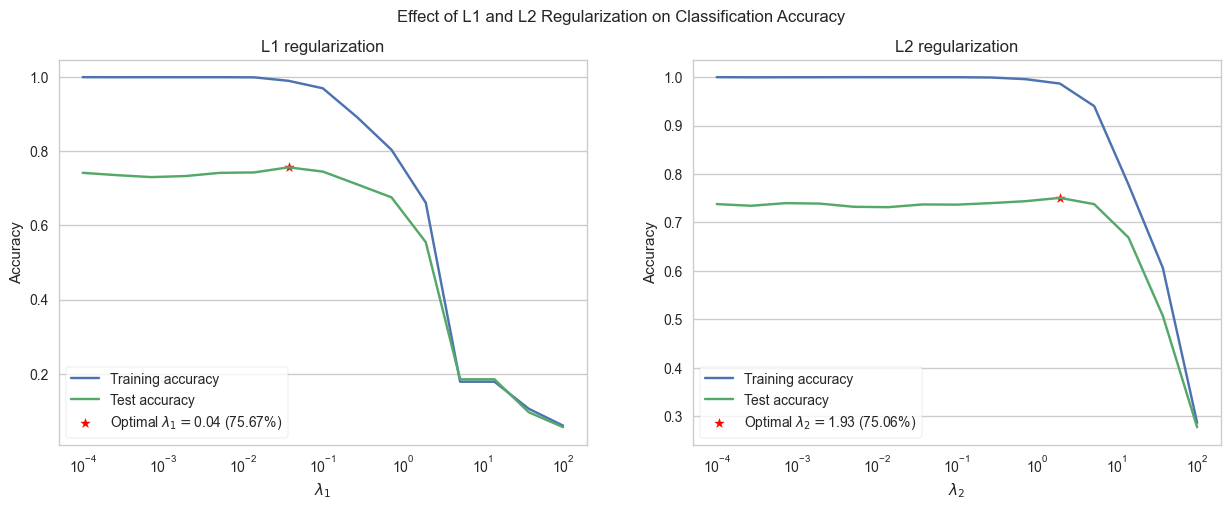

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for ax, train_scores, test_scores, name in zip(axes, [l1_train_scores, l2_train_scores], [l1_test_scores, l2_test_scores], ['L1', 'L2']):
  opt_lambda = strengths[np.argmax(test_scores)]

  ax.plot(strengths, train_scores, label='Training accuracy')
  ax.plot(strengths, test_scores, label='Test accuracy')
  ax.scatter(opt_lambda, np.max(test_scores), color='red', marker='*', label=f'Optimal $\\lambda_{name[1]} = ${opt_lambda:.2f} ({np.max(test_scores):.2%})')
  ax.set_xscale('log')
  ax.set_title(f'{name} regularization')
  ax.set_ylabel('Accuracy')
  ax.set_xlabel(f'$\\lambda_{name[1]}$')
  ax.grid(axis='x')
  ax.legend(frameon=True)

fig.suptitle("Effect of L1 and L2 Regularization on Classification Accuracy", y=0.98)
fig.savefig("3.3.png", dpi=600, bbox_inches='tight')

We see that adding regularization indeed leads to better performance on the test set for both cases! This indicates we were indeed overfitting before, so adding regularization allows us to generalize better to the test set. We note that adding L1 regularization seems to slightly outperform L2 regularization. The optimal choices for the regularization strength seem to be 0.0372 and 1.93 for L1 and L2 regularization, respectively.

### 3.4 Unnormalized input

First, let us load the unnormalized datasets.

In [62]:
transform = T.Compose([
  T.ToTensor(),
  T.Lambda(torch.flatten),
])

train = OrganAMNIST(root='./data', split='train', transform=transform, download=True)
test = OrganAMNIST(root='./data', split='test', transform=transform, download=True)
val = OrganAMNIST(root='./data', split='val', transform=transform, download=True)

x_train, y_train = np.array([x for x, _ in train]), np.array([y.item() for _, y in train])
x_test, y_test = np.array([x for x, _ in test]), np.array([y.item() for _, y in test])
x_val, y_val = np.array([x for x, _ in val]), np.array([y.item() for _, y in val])

Using downloaded and verified file: ./data/organamnist.npz
Using downloaded and verified file: ./data/organamnist.npz
Using downloaded and verified file: ./data/organamnist.npz


Now, we can evaluate the model with the unnormalized input.

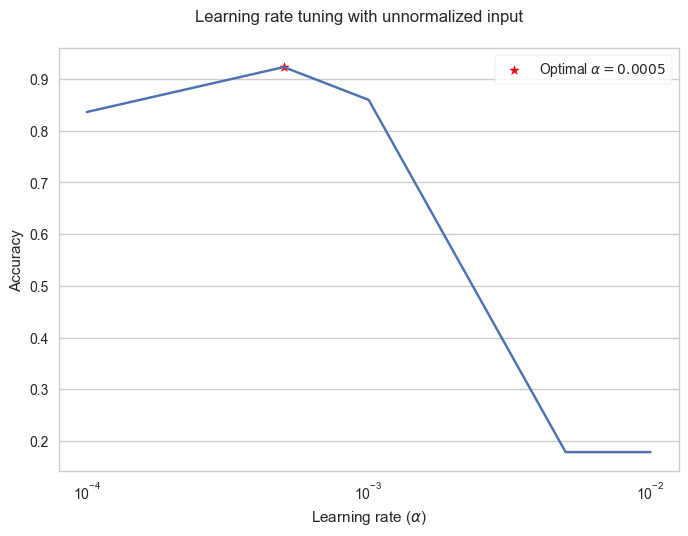

In [63]:
alpha = [0.0001, 0.0005, 0.001, 0.005, 0.01]
activation = 'relu'
arch = [x_train.shape[1], 256, 256, NUM_CLASSES]
epochs = 50

fig, ax = plt.subplots()

accuracies = grid_search(
  x_train, y_train, x_val, y_val,
  alpha,
  lambda a: MultiLayerPerceptron(activation, arch, epochs=20, alpha=a),
  lambda model, y, yh: model.evaluate_acc(y, yh)[0]
)

opt = alpha[np.argmax(accuracies)]
ax.plot(alpha, accuracies)
ax.scatter(opt, np.max(accuracies), color='red', marker='*', label=f'Optimal $\\alpha = {opt}$')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Learning rate ($\\alpha$)')
ax.set_xscale('log')
ax.grid(axis='x')
ax.legend(frameon=True)

fig.suptitle("Learning rate tuning with unnormalized input", y=0.95)
fig.savefig("3.4-loss.png", dpi=600, bbox_inches='tight')

Training accuracy: 95.91%
Test accuracy: 72.31%


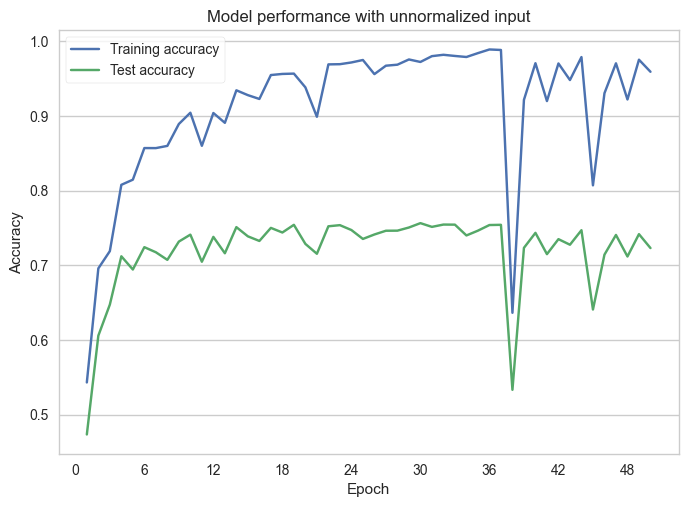

In [64]:
model = MultiLayerPerceptron(activation, arch, epochs=epochs, alpha=opt, history=True)
model.fit(x_train, y_train, x_test=x_test, y_test=y_test)

train_acc, _ = model.evaluate_acc(y_train, model.predict(x_train))
test_acc, class_acc = model.evaluate_acc(y_test, model.predict(x_test))

fig, ax = plt.subplots()

ax.plot(range(1, epochs + 1), model.record['train'], label='Training accuracy')
ax.plot(range(1, epochs + 1), model.record['test'], label='Test accuracy')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.grid(axis='x')
ax.legend(frameon=True)
ax.set_title("Model performance with unnormalized input")

print(f'Training accuracy: {train_acc:.2%}')
print(f'Test accuracy: {test_acc:.2%}')

fig.savefig("3.4.png", dpi=600, bbox_inches='tight')

As expected, we see that the larger, unnormalized pixel values lead to a noisier training process (larger, sporadic gradients). Due to this instability, the network is not able to converge to a proper classification, leading to a lower training and test accuracy.

### 3.5 Larger input size
For reference, let us first determine the compute time and epochs for training the 28 x 28 model.

In [ ]:
transform = T.Compose([
  T.ToTensor(),
  T.Normalize((mean,), (std,)),
  T.Lambda(torch.flatten),
])

train = OrganAMNIST(root='./data', split='train', transform=transform, download=True)
test = OrganAMNIST(root='./data', split='test', transform=transform, download=True)
val = OrganAMNIST(root='./data', split='val', transform=transform, download=True)

x_train, y_train = np.array([x for x, _ in train]), np.array([y.item() for _, y in train])
x_test, y_test = np.array([x for x, _ in test]), np.array([y.item() for _, y in test])
x_val, y_val = np.array([x for x, _ in val]), np.array([y.item() for _, y in val])

model = MultiLayerPerceptron('relu', [x_train.shape[1], 256, 256, NUM_CLASSES], epochs=20, alpha=0.001, history=True)

start = time()
model.fit(x_train, y_train, x_test=x_test, y_test=y_test)
print(f'Training took {time() - start:.2f}s')

train_acc, _ = model.evaluate_acc(y_train, model.predict(x_train))
test_acc, class_acc = model.evaluate_acc(y_test, model.predict(x_test))

print(f'Training accuracy: {train_acc:.2%}')
print(f'Test accuracy: {test_acc:.2%}')

Using downloaded and verified file: ./data/organamnist.npz
Using downloaded and verified file: ./data/organamnist.npz
Using downloaded and verified file: ./data/organamnist.npz
Training took 20.03s
Training accuracy: 99.99%
Test accuracy: 74.15%


We see that it took about 20s. From our experiments in 3.1, recall that it took the network about 8-10 epochs to converge. Now, let us repeat this for the 128 x 128 model. For the sake of time (as we shall see), we will not optimize the learning rate, but use a conservative value of 0.0001 instead.

In [6]:
train_loader = DataLoader(
  OrganAMNIST(root='./data', split='train', transform=T.Compose([T.ToTensor(), T.Lambda(torch.flatten)]), download=True, size=128),
  batch_size=2048
)

total = 0
sq_total = 0
N = 0

for data, _ in train_loader:
  total += data.sum()
  sq_total += (data ** 2).sum()
  N += data.numel()

mean_128, std_128 = (total / N).item(), (((sq_total / N) - (total / N) ** 2) ** 0.5).item()

transform = T.Compose([
  T.ToTensor(),
  T.Normalize((mean_128,), (std_128,)),
  T.Lambda(torch.flatten),
])

train = OrganAMNIST(root='./data', split='train', transform=transform, download=True, size=128)
test = OrganAMNIST(root='./data', split='test', transform=transform, download=True, size=128)
val = OrganAMNIST(root='./data', split='val', transform=transform, download=True, size=128)

x_train, y_train = np.array([x for x, _ in train]), np.array([y.item() for _, y in train])
x_test, y_test = np.array([x for x, _ in test]), np.array([y.item() for _, y in test])
x_val, y_val = np.array([x for x, _ in val]), np.array([y.item() for _, y in val])

Using downloaded and verified file: ./data/organamnist_128.npz


Training took 809.00s
Training accuracy: 99.88%
Test accuracy: 73.71%


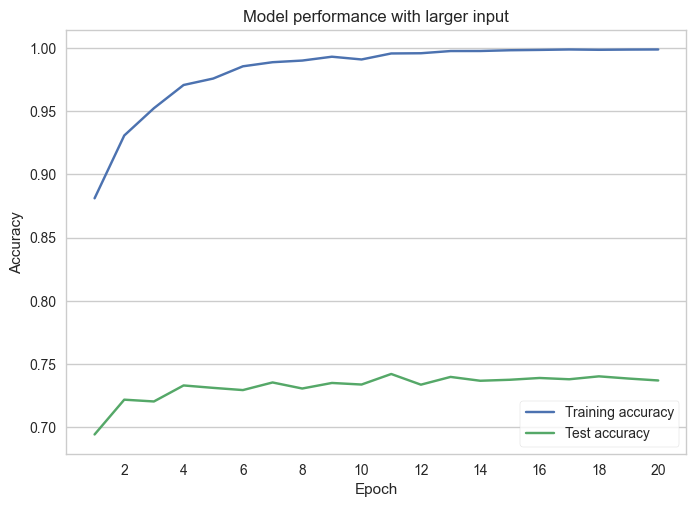

In [72]:
activation = 'relu'
alpha = 0.0001
arch = [x_train.shape[1], 256, 256, NUM_CLASSES]
epochs = 20

model = MultiLayerPerceptron(activation, arch, epochs=epochs, alpha=alpha, history=True)

start = time()
model.fit(x_train, y_train, x_test=x_test, y_test=y_test)
print(f'Training took {time() - start:.2f}s')

train_acc, _ = model.evaluate_acc(y_train, model.predict(x_train))
test_acc, class_acc = model.evaluate_acc(y_test, model.predict(x_test))

fig, ax = plt.subplots()

ax.plot(range(1, epochs + 1), model.record['train'], label='Training accuracy')
ax.plot(range(1, epochs + 1), model.record['test'], label='Test accuracy')
ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=11))
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.grid(axis='x')
ax.legend(frameon=True)
ax.set_title("Model performance with larger input")

print(f'Training accuracy: {train_acc:.2%}')
print(f'Test accuracy: {test_acc:.2%}')

fig.savefig("3.5.png", dpi=600, bbox_inches='tight')

We see that the performance is nearly identical to the case of using the 28 x 28 pixel images, with differences likely attributed to stochasticity. In terms of speed, it seems it takes a few (2-3) more epochs to converge, but more importantly, we see that the compute time has increased almost 40-fold! As such, there is no gain for the neural network when using these larger images.

### 3.6 Using convolutional neural networks.

Let us first import the necessary PyTorch modules needed for developing our CNN.

In [7]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

Now, we can implement our network as follows. We will make it generic to allow for later customization by allowing the Sequential PyTorch model to be passed in.

In [8]:
class ConvolutionalNN(nn.Module):
  def __init__(self, model: nn.Sequential, device, alpha: float = 0.0001, b: int = 256, epochs: int = 20, history: bool = False):
    super(ConvolutionalNN, self).__init__()
    self.model = model
    self.device = device
    self.optimizer = optim.Adam(self.parameters(), lr=alpha)
    self.b = b
    self.epochs = epochs
    self.history = history

    if history:
      self.record = {'train': [], 'test': []}

    self.to(device)

  def forward(self, x):
    return self.model(x)

  def fit(self, train, test):
    criterion = nn.CrossEntropyLoss()
    train_loader = DataLoader(train, batch_size=self.b, shuffle=True)
    test_loader = DataLoader(test, batch_size=self.b)

    for epoch in range(self.epochs):
      self.train()

      for im, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{self.epochs}'):
        im, labels = im.to(self.device), labels.to(self.device)
        labels = labels.flatten()

        self.optimizer.zero_grad()
        outputs = self(im)

        loss = criterion(outputs, labels)

        loss.backward()
        self.optimizer.step()

      if self.history:
        self.record['train'].append(self.evaluate_acc(train_loader))
        self.record['test'].append(self.evaluate_acc(test_loader))

  def evaluate_acc(self, loader):
    self.eval()
    correct = 0
    total = 0

    with torch.no_grad():
      for im, labels in loader:
        im, labels = im.to(self.device), labels.to(self.device)
        labels = labels.flatten()

        outputs = self(im)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return correct / total

  def evaluate_class_acc(self, loader):
    self.eval()
    class_correct = np.zeros(NUM_CLASSES)
    class_total = np.zeros(NUM_CLASSES)

    with torch.no_grad():
      for im, labels in loader:
        im, labels = im.to(self.device), labels.to(self.device)
        labels = labels.flatten()

        outputs = self(im)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()

        for i in range(len(labels)):
          label = labels[i]
          class_correct[label] += c[i].item()
          class_total[label] += 1

    return class_correct / class_total

Let us also define a convenience grid search method for our hyper-parameter tuning.

In [4]:
def grid_search(train, val, grid: list, supplier):
  scores = []

  for params in grid:
    print(f'Training model with: {params}', end=' ' * 50 + '\r')

    model = supplier(params)
    model.fit(train, val)

    scores.append(model.evalulate_acc(DataLoader(val, batch_size=2048)))

    model.to('cpu')
    del model
    torch.mps.empty_cache()

  return scores

Now, we can re-load the data and obtain our PyTorch device.

In [ ]:
transform = T.Compose([
  T.ToTensor(),
  T.Normalize((mean,), (std,)),
])

train = OrganAMNIST(root='./data', split='train', transform=transform, download=True)
test = OrganAMNIST(root='./data', split='test', transform=transform, download=True)
val = OrganAMNIST(root='./data', split='val', transform=transform, download=True)

if torch.mps.is_available():
  device = torch.device('mps')
elif torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

Let us first examine how altering the number of convolutional filters for each convolutional layer affects the network. We will retain a "same" padding with a stride of 1 for simplicity and use a filter size of 3. We will also use a standard learning rate of 0.001 (as used in the CNN Lecture Colab) for these tuning phases.

In [ ]:
filters = [256, 128, 64, 32, 16, 8]

from_filters = lambda f: nn.Sequential(
  nn.Conv2d(1, f[0], 3, 1, 1),
  nn.ReLU(),
  nn.Conv2d(f[0], f[1], 3, 1, 1),
  nn.ReLU(),
  nn.Flatten(),
  nn.Linear(f[1] * 28 * 28, 256),
  nn.ReLU(),
  nn.Linear(256, NUM_CLASSES),
)

params = list(itertools.product(filters, filters))

accuracies = grid_search(
  train, val,
  params,
  lambda f: ConvolutionalNN(model=from_filters(f), device=device, alpha=0.001, epochs=5)
)

acc_df = pd.DataFrame(zip(params, accuracies), columns=['Filters', 'Accuracy'])
acc_df

Epoch 5/5: 100%|██████████| 136/136 [02:17<00:00,  1.01s/it]


Epoch 5/5: 100%|██████████| 136/136 [01:04<00:00,  2.11it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:36<00:00,  3.68it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:20<00:00,  6.51it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:14<00:00,  9.28it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:12<00:00, 10.71it/s]


Epoch 5/5: 100%|██████████| 136/136 [01:07<00:00,  2.02it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:37<00:00,  3.63it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:27<00:00,  4.96it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:13<00:00,  9.96it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:10<00:00, 13.43it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:10<00:00, 12.74it/s]


Epoch 5/5: 100%|██████████| 136/136 [01:11<00:00,  1.90it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:36<00:00,  3.73it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:24<00:00,  5.65it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:13<00:00, 10.08it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:09<00:00, 14.84it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:06<00:00, 20.99it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:42<00:00,  3.22it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:21<00:00,  6.30it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:11<00:00, 11.48it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:07<00:00, 18.96it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:05<00:00, 27.09it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:04<00:00, 30.06it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:37<00:00,  3.66it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:19<00:00,  6.93it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:10<00:00, 12.67it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:06<00:00, 19.56it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:04<00:00, 29.17it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:03<00:00, 36.64it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:36<00:00,  3.74it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:23<00:00,  5.78it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:11<00:00, 11.83it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:10<00:00, 12.44it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:05<00:00, 27.19it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:03<00:00, 36.39it/s]


,Filters,Accuracy
0,"(256, 256)",0.917116
1,"(256, 128)",0.873209
2,"(256, 64)",0.159143
3,"(256, 32)",0.897859
4,"(256, 16)",0.159143
5,"(256, 8)",0.159143
6,"(128, 256)",0.853489
7,"(128, 128)",0.849638
8,"(128, 64)",0.159143
9,"(128, 32)",0.868279


In [55]:
acc_df['F1'], acc_df['F2'] = zip(*acc_df['Filters'])
acc_df = acc_df.drop(columns=['Filters'])
acc_df = acc_df.sort_values('Accuracy', ascending=False)
acc_df

,Accuracy,F1,F2
33,0.963642,8,32
34,0.962718,8,16
30,0.961947,8,256
31,0.958250,8,128
25,0.948698,16,128
29,0.945617,16,8
35,0.945463,8,8
18,0.941920,32,256
32,0.940841,8,64
23,0.940071,32,8


From this, we see that using 8 filters for the first layer tends to lead to better performance. Of those, having 32 filters in the second layer seems to edge out the other configurations. Interestingly, it seems that the lower 11 (when sorted by accuracy) configurations may have faced a similar problem leading to an abysmal final result. It may have been the case that the gradient descent diverged, leading to a sub-optimal minima. We see that a common pattern with these final 11 is that they each have a larger number of filters in the first layer, and then fewer in the second layer. From this, it seems that fewer then higher convolutional filters is a better configuration.

Now, using our optimal configuration, let us examine how playing with the filter size affects the network.

In [ ]:
sizes = [11, 9, 7, 5, 3]

from_sizes = lambda s: nn.Sequential(
  nn.Conv2d(1, 8, s[0], 1, int(np.floor(s[0] / 2))),
  nn.ReLU(),
  nn.Conv2d(8, 32, s[1], 1, int(np.floor(s[1] / 2))),
  nn.ReLU(),
  nn.Flatten(),
  nn.Linear(32 * 28 * 28, 256),
  nn.ReLU(),
  nn.Linear(256, NUM_CLASSES),
)

params = list(itertools.product(sizes, sizes))

accuracies = grid_search(
  train, val,
  params,
  lambda s: ConvolutionalNN(model=from_sizes(s), device=device, alpha=0.001, epochs=5)
)

acc_df = pd.DataFrame(zip(params, accuracies), columns=['Sizes', 'Accuracy'])

Epoch 5/5: 100%|██████████| 136/136 [00:15<00:00,  8.53it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:13<00:00,  9.79it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:11<00:00, 11.96it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:08<00:00, 15.37it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:07<00:00, 19.07it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:17<00:00,  7.74it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:13<00:00,  9.99it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:11<00:00, 11.80it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:10<00:00, 12.64it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:06<00:00, 19.73it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:16<00:00,  8.14it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:12<00:00, 10.63it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:11<00:00, 11.92it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:07<00:00, 17.56it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:06<00:00, 22.41it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:16<00:00,  8.31it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:12<00:00, 10.70it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:09<00:00, 13.82it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:07<00:00, 17.53it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:05<00:00, 22.88it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:17<00:00,  7.64it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:12<00:00, 10.58it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:10<00:00, 13.54it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:07<00:00, 17.09it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:05<00:00, 23.25it/s]


In [62]:
acc_df['S1'], acc_df['S2'] = zip(*acc_df['Sizes'])
acc_df = acc_df.drop(columns=['Sizes'])
acc_df = acc_df.sort_values('Accuracy', ascending=False)
acc_df

,Accuracy,S1,S2
9,0.949777,9,3
19,0.948544,5,3
24,0.948082,3,3
23,0.940995,3,5
4,0.938222,11,3
14,0.934987,7,3
18,0.929133,5,5
15,0.912032,5,11
20,0.908643,3,11
22,0.900169,3,7


It seems that having a kernel of size 3 in the final layer is key to good performance. With this, it seems that having a kernel of size 9 is optimal for our configuration.

Now, to (somewhat) alleviate the effect of randomness, we will test the top 2 of each configuration for 10 iterations and then determine our most optimal model.

In [ ]:
sizes = [(9, 3), (5, 3)]
filters = [(8, 32), (8, 16)]

from_params = lambda f, s: nn.Sequential(
  nn.Conv2d(1, f[0], s[0], 1, int(np.floor(s[0] / 2))),
  nn.ReLU(),
  nn.Conv2d(f[0], f[1], s[1], 1, int(np.floor(s[1] / 2))),
  nn.ReLU(),
  nn.Flatten(),
  nn.Linear(f[1] * 28 * 28, 256),
  nn.ReLU(),
  nn.Linear(256, NUM_CLASSES),
)

params = list(itertools.product(filters, sizes))
accs = []

for _ in range(10):
  accuracies = grid_search(
    train, val,
    params,
    lambda p: ConvolutionalNN(model=from_params(*p), device=device, alpha=0.001, epochs=5)
  )

  accs.append(accuracies)

accuracies = np.mean(accs, axis=0)
acc_df = pd.DataFrame(zip(params, accuracies), columns=['Params', 'Accuracy'])

Epoch 5/5: 100%|██████████| 136/136 [00:06<00:00, 21.33it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:05<00:00, 24.55it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:04<00:00, 27.89it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:03<00:00, 34.32it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:05<00:00, 22.69it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:05<00:00, 23.58it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:04<00:00, 30.04it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:04<00:00, 30.10it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:06<00:00, 21.61it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:05<00:00, 23.89it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:04<00:00, 30.54it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:03<00:00, 34.78it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:06<00:00, 21.98it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:06<00:00, 20.92it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:04<00:00, 29.78it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:04<00:00, 33.48it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:08<00:00, 15.76it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:06<00:00, 22.66it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:05<00:00, 26.61it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:04<00:00, 29.22it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:07<00:00, 19.31it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:07<00:00, 18.19it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:05<00:00, 26.69it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:04<00:00, 32.73it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:06<00:00, 21.05it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:06<00:00, 22.53it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:04<00:00, 28.41it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:05<00:00, 26.78it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:06<00:00, 19.60it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:05<00:00, 23.38it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:04<00:00, 29.70it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:03<00:00, 34.73it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:06<00:00, 20.01it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:05<00:00, 23.08it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:04<00:00, 29.90it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:04<00:00, 29.18it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:06<00:00, 22.41it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:05<00:00, 25.04it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:04<00:00, 28.21it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:03<00:00, 34.53it/s]


In [64]:
acc_df['F1'], acc_df['F2'] = zip(*acc_df['Params'].apply(lambda x: x[0]))
acc_df['S1'], acc_df['S2'] = zip(*acc_df['Params'].apply(lambda x: x[1]))
acc_df = acc_df.drop(columns=['Params'])
acc_df = acc_df.sort_values('Accuracy', ascending=False)
acc_df

,Accuracy,F1,F2,S1,S2
3,0.945093,8,16,5,3
1,0.943306,8,32,5,3
2,0.937190,8,16,9,3
0,0.935049,8,32,9,3


Looks like our optimal model has 8 convolution filters of size 5 in the first layer and 16 of size 3 in the second! Finally, let us optimize our learning rate over this final architecture.

Epoch 5/5: 100%|██████████| 136/136 [00:03<00:00, 35.65it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:03<00:00, 34.22it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:03<00:00, 34.33it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:04<00:00, 30.87it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:04<00:00, 32.93it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:04<00:00, 32.26it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:03<00:00, 34.85it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:03<00:00, 35.64it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:03<00:00, 35.79it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:05<00:00, 26.03it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:04<00:00, 33.13it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:04<00:00, 30.80it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:04<00:00, 31.00it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:03<00:00, 35.24it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:03<00:00, 35.30it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:03<00:00, 35.41it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:03<00:00, 35.32it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:04<00:00, 33.68it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:03<00:00, 35.61it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:04<00:00, 30.25it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:04<00:00, 32.59it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:03<00:00, 34.68it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:03<00:00, 35.09it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:04<00:00, 33.03it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:03<00:00, 34.32it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:04<00:00, 33.52it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:04<00:00, 30.76it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:04<00:00, 33.28it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:04<00:00, 31.15it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:04<00:00, 33.68it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:05<00:00, 23.81it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:06<00:00, 21.99it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:05<00:00, 25.21it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:04<00:00, 27.36it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:04<00:00, 31.67it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:04<00:00, 30.83it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:04<00:00, 32.54it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:04<00:00, 32.45it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:05<00:00, 25.31it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:04<00:00, 32.17it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:04<00:00, 33.05it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:04<00:00, 30.86it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:04<00:00, 32.26it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:04<00:00, 32.93it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:04<00:00, 32.20it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:06<00:00, 21.95it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:05<00:00, 24.45it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:05<00:00, 23.51it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:04<00:00, 32.09it/s]


Epoch 5/5: 100%|██████████| 136/136 [00:04<00:00, 32.59it/s]


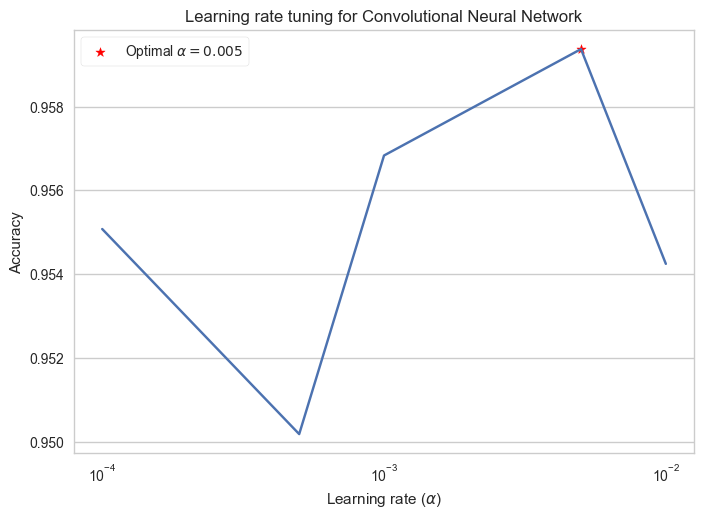

In [71]:
seq = nn.Sequential(
  nn.Conv2d(1, 8, 5, 1, 2),
  nn.ReLU(),
  nn.Conv2d(8, 16, 3, 1, 1),
  nn.ReLU(),
  nn.Flatten(),
  nn.Linear(16 * 28 * 28, 256),
  nn.ReLU(),
  nn.Linear(256, NUM_CLASSES),
)

alpha = [0.0001, 0.0005, 0.001, 0.005, 0.01]
accs = []

for _ in range(10):
  accuracies = grid_search(
    train, val,
    alpha,
    lambda a: ConvolutionalNN(model=seq, device=device, alpha=a, epochs=5)
  )

  accs.append(accuracies)

accuracies = np.mean(accs, axis=0)

opt = alpha[np.argmax(accuracies)]

plt.plot(alpha, accuracies)
plt.scatter(opt, np.max(accuracies), color='red', marker='*', label=f'Optimal $\\alpha = {opt}$')
plt.ylabel('Accuracy')
plt.xlabel('Learning rate ($\\alpha$)')
plt.xscale('log')
plt.grid(axis='x')
plt.legend(frameon=True)
plt.title("Learning rate tuning for Convolutional Neural Network")

plt.savefig("3.6-loss.png", dpi=600, bbox_inches='tight')

We note that there is not much variation between the different learning rates (all fall within a 1% window). With this, let us now compare the performance of our final CNN to our multilayer perceptron.

Epoch 20/20: 100%|██████████| 136/136 [00:04<00:00, 32.89it/s]


Training accuracy: 100.00%
Test accuracy: 85.49%


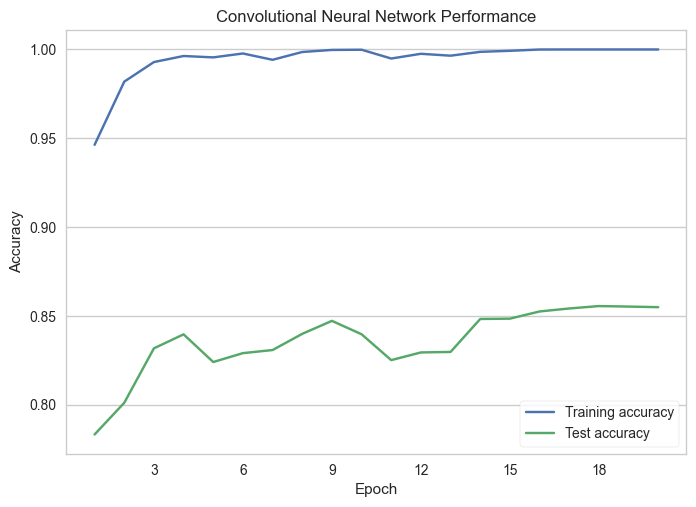

In [77]:
alpha = 0.005
epochs = 20
seq = nn.Sequential(
  nn.Conv2d(1, 8, 5, 1, 2),
  nn.ReLU(),
  nn.Conv2d(8, 16, 3, 1, 1),
  nn.ReLU(),
  nn.Flatten(),
  nn.Linear(16 * 28 * 28, 256),
  nn.ReLU(),
  nn.Linear(256, NUM_CLASSES),
)

model = ConvolutionalNN(seq, device, alpha=alpha, epochs=epochs, history=True)
model.fit(train, test)

train_acc = model.record['train'][-1]
test_acc = model.record['test'][-1]

print(f'Training accuracy: {train_acc:.2%}')
print(f'Test accuracy: {test_acc:.2%}')

fig, ax = plt.subplots()

ax.plot(range(1, epochs + 1), model.record['train'], label='Training accuracy')
ax.plot(range(1, epochs + 1), model.record['test'], label='Test accuracy')

ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.grid(axis='x')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend(frameon=True)
ax.set_title("Convolutional Neural Network Performance")

fig.savefig("3.6.png", dpi=600, bbox_inches='tight')

As expected, we see that the CNN performs much better than our MLP! We see an increase of about 10% in test performance. This of course is due to the fact that CNNs are more apt for handling image data, as opposed to MLPs that cannot recognize the image patterns. Moreover, we see that the CNN converges to 100% training accuracy almost immediately, but this may likely be attributed to the efficiencies of the PyTorch setup (e.g., Adam optimizer). At the same time, we also see that the training is a bit more noisy than our MLP implementation.

### 3.7 Larger images with CNNs

Let us load up our 128 pixel image data.

In [105]:
transform = T.Compose([
  T.ToTensor(),
  T.Normalize((mean_128,), (std_128,)),
])

train = OrganAMNIST(root='./data', split='train', transform=transform, download=True, size=128)
test = OrganAMNIST(root='./data', split='test', transform=transform, download=True, size=128)
val = OrganAMNIST(root='./data', split='val', transform=transform, download=True, size=128)

Using downloaded and verified file: ./data/organamnist_128.npz
Using downloaded and verified file: ./data/organamnist_128.npz
Using downloaded and verified file: ./data/organamnist_128.npz


Now, we will will test out a few different models, including the one from above. We will play around with (1) adding more fully connected layers, (2) adding more hidden units in the fully connected layers, and (3) adding max-pooling layers. We will alter the base model with each of the 3 adjustments individually, take the best 2 from each, and then combine them to see what yields the best results. To limit computation, we will train on ~10K images (around a third of the training set).

In [144]:
tuning_train = list(itertools.islice(train, 10000))

In [152]:
# (1) and (2): Testing different fully connected layers

base = [nn.Conv2d(1, 8, 5, 1, 2), nn.ReLU(), nn.Conv2d(8, 16, 3, 1, 1), nn.ReLU(), nn.Flatten()]

seqs = [
  nn.Sequential(*base, nn.Linear(16 * 128 * 128, 512), nn.ReLU(), nn.Linear(512, 256), nn.ReLU(), nn.Linear(256, NUM_CLASSES)),
  nn.Sequential(*base, nn.Linear(16 * 128 * 128, 256), nn.ReLU(), nn.Linear(256, 256), nn.ReLU(), nn.Linear(256, NUM_CLASSES)),
  nn.Sequential(*base, nn.Linear(16 * 128 * 128, 128), nn.ReLU(), nn.Linear(128, 64), nn.ReLU(), nn.Linear(64, NUM_CLASSES)),
  nn.Sequential(*base, nn.Linear(16 * 128 * 128, 256), nn.ReLU(), nn.Linear(256, 256), nn.ReLU(), nn.Linear(256, 128), nn.ReLU(), nn.Linear(128, NUM_CLASSES)),
  nn.Sequential(*base, nn.Linear(16 * 128 * 128, 512), nn.ReLU(), nn.Linear(512, 256), nn.ReLU(), nn.Linear(256, 128), nn.ReLU(), nn.Linear(128, NUM_CLASSES)),
  nn.Sequential(*base, nn.Linear(16 * 128 * 128, 256), nn.ReLU(), nn.Linear(256, 128), nn.ReLU(), nn.Linear(128, 128), nn.ReLU(), nn.Linear(128, 64), nn.ReLU(), nn.Linear(64, NUM_CLASSES)),
]

params = [(512, 256), (256, 256), (128, 64), (256, 256, 128), (512, 256, 128), (256, 128, 128, 64)]
accuracies = grid_search(
  tuning_train, val,
  seqs,
  lambda s: ConvolutionalNN(model=s, device=device, alpha=0.005, epochs=10)
)

acc_df = pd.DataFrame(zip(params, accuracies), columns=['Architecture', 'Accuracy'])

Training model with: Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=262144, out_features=512, bias=True)
  (6): ReLU()
  (7): Linear(in_features=512, out_features=256, bias=True)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=11, bias=True)


Epoch 10/10: 100%|██████████| 40/40 [00:28<00:00,  1.38it/s]


Training model with: Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=262144, out_features=256, bias=True)
  (6): ReLU()
  (7): Linear(in_features=256, out_features=256, bias=True)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=11, bias=True)


Epoch 10/10: 100%|██████████| 40/40 [00:17<00:00,  2.27it/s]


Training model with: Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=262144, out_features=128, bias=True)
  (6): ReLU()
  (7): Linear(in_features=128, out_features=64, bias=True)
  (8): ReLU()
  (9): Linear(in_features=64, out_features=11, bias=True)


Epoch 10/10: 100%|██████████| 40/40 [00:11<00:00,  3.45it/s]


Training model with: Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=262144, out_features=256, bias=True)
  (6): ReLU()
  (7): Linear(in_features=256, out_features=256, bias=True)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=128, bias=True)
  (10): ReLU()
  (11): Linear(in_features=128, out_features=11, bias=True)


Epoch 10/10: 100%|██████████| 40/40 [00:14<00:00,  2.68it/s]


Training model with: Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=262144, out_features=512, bias=True)
  (6): ReLU()
  (7): Linear(in_features=512, out_features=256, bias=True)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=128, bias=True)
  (10): ReLU()
  (11): Linear(in_features=128, out_features=11, bias=True)


Epoch 10/10: 100%|██████████| 40/40 [00:28<00:00,  1.39it/s]


Training model with: Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=262144, out_features=256, bias=True)
  (6): ReLU()
  (7): Linear(in_features=256, out_features=128, bias=True)
  (8): ReLU()
  (9): Linear(in_features=128, out_features=128, bias=True)
  (10): ReLU()
  (11): Linear(in_features=128, out_features=64, bias=True)
  (12): ReLU()
  (13): Linear(in_features=64, out_features=11, bias=True)


Epoch 10/10: 100%|██████████| 40/40 [00:15<00:00,  2.55it/s]


In [153]:
acc_df = acc_df.sort_values('Accuracy', ascending=False)
acc_df

,Architecture,Accuracy
4,"(512, 256, 128)",0.949931
5,"(256, 128, 128, 64)",0.945925
3,"(256, 256, 128)",0.935295
2,"(128, 64)",0.931598
1,"(256, 256)",0.909105
0,"(512, 256)",0.877215


In [155]:
# (3): Testing max pooling layers

seqs = [
  nn.Sequential(nn.Conv2d(1, 8, 5, 1, 2), nn.MaxPool2d(2), nn.Conv2d(8, 16, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2), nn.Flatten(), nn.Linear(32 * 32 * 16, 256), nn.ReLU(), nn.Linear(256, NUM_CLASSES)),
  nn.Sequential(nn.Conv2d(1, 8, 5, 1, 2), nn.MaxPool2d(4), nn.Conv2d(8, 16, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2), nn.Flatten(), nn.Linear(16 * 16 * 16, 256), nn.ReLU(), nn.Linear(256, NUM_CLASSES)),
  nn.Sequential(nn.Conv2d(1, 8, 5, 1, 2), nn.MaxPool2d(2), nn.Conv2d(8, 16, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(4), nn.Flatten(), nn.Linear(16 * 16 * 16, 256), nn.ReLU(), nn.Linear(256, NUM_CLASSES)),
  nn.Sequential(nn.Conv2d(1, 8, 5, 1, 2), nn.MaxPool2d(4), nn.Conv2d(8, 16, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(4), nn.Flatten(), nn.Linear(8 * 8 * 16, 256), nn.ReLU(), nn.Linear(256, NUM_CLASSES)),

  nn.Sequential(nn.Conv2d(1, 8, 5, 1, 2), nn.MaxPool2d(2), nn.Conv2d(8, 16, 3, 1, 1), nn.ReLU(), nn.Flatten(), nn.Linear(64 * 64 * 16, 256), nn.ReLU(), nn.Linear(256, NUM_CLASSES)),
  nn.Sequential(nn.Conv2d(1, 8, 5, 1, 2), nn.ReLU(), nn.Conv2d(8, 16, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2), nn.Flatten(), nn.Linear(64 * 64 * 16, 256), nn.ReLU(), nn.Linear(256, NUM_CLASSES)),
  nn.Sequential(nn.Conv2d(1, 8, 5, 1, 2), nn.MaxPool2d(4), nn.Conv2d(8, 16, 3, 1, 1), nn.ReLU(), nn.Flatten(), nn.Linear(32 * 32 * 16, 256), nn.ReLU(), nn.Linear(256, NUM_CLASSES)),
  nn.Sequential(nn.Conv2d(1, 8, 5, 1, 2), nn.ReLU(), nn.Conv2d(8, 16, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(4), nn.Flatten(), nn.Linear(32 * 32 * 16, 256), nn.ReLU(), nn.Linear(256, NUM_CLASSES)),
]

params = [(2, 2), (4, 2), (2, 4), (4, 4), (2, 0), (0, 2), (4, 0), (0, 4)]
accuracies = grid_search(
  tuning_train, val,
  seqs,
  lambda s: ConvolutionalNN(model=s, device=device, alpha=0.005, epochs=10)
)

acc_df = pd.DataFrame(zip(params, accuracies), columns=['Architecture', 'Accuracy'])

Training model with: Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=16384, out_features=256, bias=True)
  (7): ReLU()
  (8): Linear(in_features=256, out_features=11, bias=True)


Epoch 10/10: 100%|██████████| 40/40 [00:03<00:00, 10.54it/s]


Training model with: Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=4096, out_features=256, bias=True)
  (7): ReLU()
  (8): Linear(in_features=256, out_features=11, bias=True)


Epoch 10/10: 100%|██████████| 40/40 [00:02<00:00, 15.83it/s]


Training model with: Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=4096, out_features=256, bias=True)
  (7): ReLU()
  (8): Linear(in_features=256, out_features=11, bias=True)


Epoch 10/10: 100%|██████████| 40/40 [00:03<00:00, 12.29it/s]


Training model with: Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=1024, out_features=256, bias=True)
  (7): ReLU()
  (8): Linear(in_features=256, out_features=11, bias=True)


Epoch 10/10: 100%|██████████| 40/40 [00:02<00:00, 16.09it/s]


Training model with: Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=65536, out_features=256, bias=True)
  (6): ReLU()
  (7): Linear(in_features=256, out_features=11, bias=True)


Epoch 10/10: 100%|██████████| 40/40 [00:05<00:00,  7.82it/s]


Training model with: Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=65536, out_features=256, bias=True)
  (7): ReLU()
  (8): Linear(in_features=256, out_features=11, bias=True)


Epoch 10/10: 100%|██████████| 40/40 [00:08<00:00,  4.87it/s]


Training model with: Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=16384, out_features=256, bias=True)
  (6): ReLU()
  (7): Linear(in_features=256, out_features=11, bias=True)


Epoch 10/10: 100%|██████████| 40/40 [00:02<00:00, 14.11it/s]


Training model with: Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=16384, out_features=256, bias=True)
  (7): ReLU()
  (8): Linear(in_features=256, out_features=11, bias=True)


Epoch 10/10: 100%|██████████| 40/40 [00:06<00:00,  6.02it/s]


In [156]:
acc_df = acc_df.sort_values('Accuracy', ascending=False)
acc_df

,Architecture,Accuracy
0,"(2, 2)",0.962718
2,"(2, 4)",0.956093
1,"(4, 2)",0.954244
3,"(4, 4)",0.951933
4,"(2, 0)",0.931444
6,"(4, 0)",0.881066
7,"(0, 4)",0.874750
5,"(0, 2)",0.810661


Now, we will combine the top 2 models of each test, the individual models themselves, and the original standard model and examine which is best! We will also use the full dataset for training.

In [163]:
seqs = [
  # Original models
  nn.Sequential(nn.Conv2d(1, 8, 5, 1, 2), nn.ReLU(), nn.Conv2d(8, 16, 3, 1, 1), nn.ReLU(), nn.Flatten(), nn.Linear(16 * 128 * 128, 256), nn.ReLU(), nn.Linear(256, NUM_CLASSES)),
  nn.Sequential(nn.Conv2d(1, 8, 5, 1, 2), nn.ReLU(), nn.Conv2d(8, 16, 3, 1, 1), nn.ReLU(), nn.Flatten(), nn.Linear(16 * 128 * 128, 512), nn.ReLU(), nn.Linear(512, 256), nn.ReLU(), nn.Linear(256, 128), nn.ReLU(), nn.Linear(128, NUM_CLASSES)),
  nn.Sequential(nn.Conv2d(1, 8, 5, 1, 2), nn.ReLU(), nn.Conv2d(8, 16, 3, 1, 1), nn.ReLU(), nn.Flatten(), nn.Linear(16 * 128 * 128, 256), nn.ReLU(), nn.Linear(256, 128), nn.ReLU(), nn.Linear(128, 128), nn.ReLU(), nn.Linear(128, 64), nn.ReLU(), nn.Linear(64, NUM_CLASSES)),
  nn.Sequential(nn.Conv2d(1, 8, 5, 1, 2), nn.MaxPool2d(2), nn.Conv2d(8, 16, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2), nn.Flatten(), nn.Linear(32 * 32 * 16, 256), nn.ReLU(), nn.Linear(256, NUM_CLASSES)),
  nn.Sequential(nn.Conv2d(1, 8, 5, 1, 2), nn.MaxPool2d(2), nn.Conv2d(8, 16, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(4), nn.Flatten(), nn.Linear(16 * 16 * 16, 256), nn.ReLU(), nn.Linear(256, NUM_CLASSES)),

  # Combined models
  nn.Sequential(nn.Conv2d(1, 8, 5, 1, 2), nn.MaxPool2d(2), nn.Conv2d(8, 16, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2), nn.Flatten(), nn.Linear(32 * 32 * 16, 512), nn.ReLU(), nn.Linear(512, 256), nn.ReLU(), nn.Linear(256, 128), nn.ReLU(), nn.Linear(128, NUM_CLASSES)),
  nn.Sequential(nn.Conv2d(1, 8, 5, 1, 2), nn.MaxPool2d(2), nn.Conv2d(8, 16, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2), nn.Flatten(), nn.Linear(32 * 32 * 16, 256), nn.ReLU(), nn.Linear(256, 128), nn.ReLU(), nn.Linear(128, 128), nn.ReLU(), nn.Linear(128, 64), nn.ReLU(), nn.Linear(64, NUM_CLASSES)),
  nn.Sequential(nn.Conv2d(1, 8, 5, 1, 2), nn.MaxPool2d(2), nn.Conv2d(8, 16, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(4), nn.Flatten(), nn.Linear(16 * 16 * 16, 512), nn.ReLU(), nn.Linear(512, 256), nn.ReLU(), nn.Linear(256, 128), nn.ReLU(), nn.Linear(128, NUM_CLASSES)),
  nn.Sequential(nn.Conv2d(1, 8, 5, 1, 2), nn.MaxPool2d(2), nn.Conv2d(8, 16, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(4), nn.Flatten(), nn.Linear(16 * 16 * 16, 256), nn.ReLU(), nn.Linear(256, 128), nn.ReLU(), nn.Linear(128, 128), nn.ReLU(), nn.Linear(128, 64), nn.ReLU(), nn.Linear(64, NUM_CLASSES)),
]

params = [(0, 0, 256), (0, 0, 512, 256, 128), (0, 0, 256, 128, 128, 64), (2, 2, 256), (2, 4, 256), (2, 2, 512, 256, 128), (2, 2, 256, 128, 128, 64), (2, 4, 512, 256, 128), (2, 4, 256, 128, 128, 64)]
accuracies = grid_search(
  train, val,
  seqs,
  lambda s: ConvolutionalNN(model=s, device=device, alpha=0.005, epochs=10)
)

acc_df = pd.DataFrame(zip(params, accuracies), columns=['Architecture', 'Accuracy'])

Training model with: Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=262144, out_features=256, bias=True)
  (6): ReLU()
  (7): Linear(in_features=256, out_features=11, bias=True)


Epoch 10/10: 100%|██████████| 136/136 [00:59<00:00,  2.27it/s]


Training model with: Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=262144, out_features=512, bias=True)
  (6): ReLU()
  (7): Linear(in_features=512, out_features=256, bias=True)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=128, bias=True)
  (10): ReLU()
  (11): Linear(in_features=128, out_features=11, bias=True)


Epoch 10/10: 100%|██████████| 136/136 [01:48<00:00,  1.26it/s]


Training model with: Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=262144, out_features=256, bias=True)
  (6): ReLU()
  (7): Linear(in_features=256, out_features=128, bias=True)
  (8): ReLU()
  (9): Linear(in_features=128, out_features=128, bias=True)
  (10): ReLU()
  (11): Linear(in_features=128, out_features=64, bias=True)
  (12): ReLU()
  (13): Linear(in_features=64, out_features=11, bias=True)


Epoch 10/10: 100%|██████████| 136/136 [01:12<00:00,  1.88it/s]


Training model with: Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=16384, out_features=256, bias=True)
  (7): ReLU()
  (8): Linear(in_features=256, out_features=11, bias=True)


Epoch 10/10: 100%|██████████| 136/136 [00:19<00:00,  7.04it/s]


Training model with: Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=4096, out_features=256, bias=True)
  (7): ReLU()
  (8): Linear(in_features=256, out_features=11, bias=True)


Epoch 10/10: 100%|██████████| 136/136 [00:18<00:00,  7.39it/s]


Training model with: Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=16384, out_features=512, bias=True)
  (7): ReLU()
  (8): Linear(in_features=512, out_features=256, bias=True)
  (9): ReLU()
  (10): Linear(in_features=256, out_features=128, bias=True)
  (11): ReLU()
  (12): Linear(in_features=128, out_features=11, bias=True)


Epoch 10/10: 100%|██████████| 136/136 [00:19<00:00,  6.91it/s]


Training model with: Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=16384, out_features=256, bias=True)
  (7): ReLU()
  (8): Linear(in_features=256, out_features=128, bias=True)
  (9): ReLU()
  (10): Linear(in_features=128, out_features=128, bias=True)
  (11): ReLU()
  (12): Linear(in_features=128, out_features=64, bias=True)
  (13): ReLU()
  (14): Linear(in_features=64, out_features=11, bias=True)


Epoch 10/10: 100%|██████████| 136/136 [00:17<00:00,  7.71it/s]


Training model with: Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=4096, out_features=512, bias=True)
  (7): ReLU()
  (8): Linear(in_features=512, out_features=256, bias=True)
  (9): ReLU()
  (10): Linear(in_features=256, out_features=128, bias=True)
  (11): ReLU()
  (12): Linear(in_features=128, out_features=11, bias=True)


Epoch 10/10: 100%|██████████| 136/136 [00:19<00:00,  7.05it/s]


Training model with: Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=4096, out_features=256, bias=True)
  (7): ReLU()
  (8): Linear(in_features=256, out_features=128, bias=True)
  (9): ReLU()
  (10): Linear(in_features=128, out_features=128, bias=True)
  (11): ReLU()
  (12): Linear(in_features=128, out_features=64, bias=True)
  (13): ReLU()
  (14): Linear(in_features=64, out_features=11, bias=True)


Epoch 10/10: 100%|██████████| 136/136 [00:18<00:00,  7.52it/s]


In [164]:
acc_df = acc_df.sort_values('Accuracy', ascending=False)
acc_df

,Architecture,Accuracy
4,"(2, 4, 256)",0.968418
8,"(2, 4, 256, 128, 128, 64)",0.964412
6,"(2, 2, 256, 128, 128, 64)",0.957942
5,"(2, 2, 512, 256, 128)",0.955477
2,"(0, 0, 256, 128, 128, 64)",0.950239
3,"(2, 2, 256)",0.931289
7,"(2, 4, 512, 256, 128)",0.931289
0,"(0, 0, 256)",0.924511
1,"(0, 0, 512, 256, 128)",0.921738


As such, although it seems that adding more fully connected layers is helpful, it seems simplicity succeeds and that simply having 2 max-pooling layers is the best. We will now examine the training curve for this model and evaluate the performance in comparison to the previous models!

Epoch 20/20: 100%|██████████| 136/136 [00:15<00:00,  8.89it/s]


Training accuracy: 100.00%
Test accuracy: 89.01%


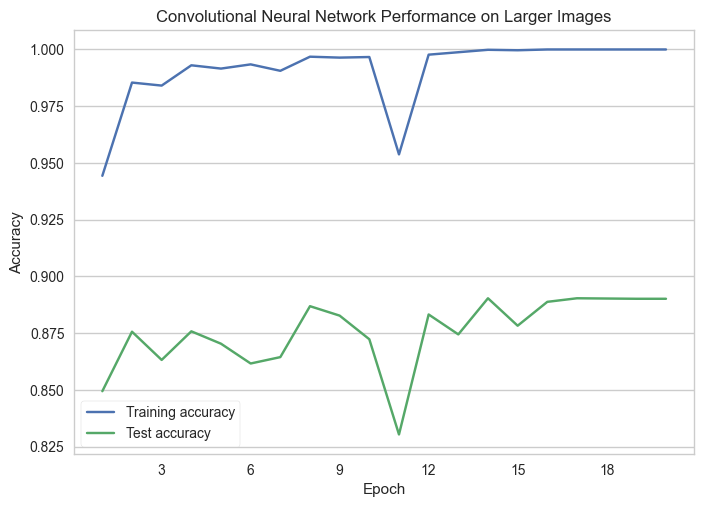

In [168]:
alpha = 0.005
epochs = 20
seq = nn.Sequential(
  nn.Conv2d(1, 8, 5, 1, 2),
  nn.MaxPool2d(2),
  nn.Conv2d(8, 16, 3, 1, 1),
  nn.ReLU(),
  nn.MaxPool2d(4),
  nn.Flatten(),
  nn.Linear(16 * 16 * 16, 256),
  nn.ReLU(),
  nn.Linear(256, NUM_CLASSES)
)

model = ConvolutionalNN(seq, device, alpha=alpha, epochs=epochs, history=True)
model.fit(train, test)

train_acc = model.record['train'][-1]
test_acc = model.record['test'][-1]

print(f'Training accuracy: {train_acc:.2%}')
print(f'Test accuracy: {test_acc:.2%}')

fig, ax = plt.subplots()

ax.plot(range(1, epochs + 1), model.record['train'], label='Training accuracy')
ax.plot(range(1, epochs + 1), model.record['test'], label='Test accuracy')

ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.grid(axis='x')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend(frameon=True)
ax.set_title("Convolutional Neural Network Performance on Larger Images")

fig.savefig("3.7.png", dpi=600, bbox_inches='tight')

We see that the we have an 89% accuracy after modifications! As before, we see that using larger images leads to a slow down during training, both in compute time and in the number of epochs it takes to train the model. Unlike with the MLP, we see that using the larger images, in conjunction with using the max-pooling, allowed for an increase in performance!

### 3.8 Using pre-trained models
We will utilise AlexNet as our pre-trained model. Let us define a wrapper class to make some things easier.

In [11]:
from torchvision.models import alexnet, AlexNet_Weights

OUTPUT_DIM = 256 * 6 * 6

In [12]:
class AlexNet(nn.Module):
  def __init__(self, classifier: nn.Sequential, device, alpha: float = 0.0001, b: int = 256, epochs: int = 20, history: bool = False):
    super(AlexNet, self).__init__()
    self.model = alexnet(weights=AlexNet_Weights.DEFAULT)

    for param in self.model.parameters():
      param.requires_grad = False

    self.model.classifier = classifier

    self.device = device
    self.optimizer = optim.Adam(self.parameters(), lr=alpha)
    self.b = b
    self.epochs = epochs
    self.history = history

    if history:
      self.record = {'train': [], 'test': []}

    self.to(device)

  def forward(self, x):
    return self.model(x)

  def fit(self, train, test):
    criterion = nn.CrossEntropyLoss()
    train_loader = DataLoader(train, batch_size=self.b, shuffle=True)
    test_loader = DataLoader(test, batch_size=self.b)

    for epoch in range(self.epochs):
      self.train()

      for im, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{self.epochs}'):
        im, labels = im.to(self.device), labels.to(self.device)
        labels = labels.flatten()

        self.optimizer.zero_grad()
        outputs = self(im)

        loss = criterion(outputs, labels)

        loss.backward()
        self.optimizer.step()

      if self.history:
        self.record['train'].append(self.evaluate_acc(train_loader))
        self.record['test'].append(self.evaluate_acc(test_loader))

  def evaluate_acc(self, loader):
    self.eval()
    correct = 0
    total = 0

    with torch.no_grad():
      for im, labels in loader:
        im, labels = im.to(self.device), labels.to(self.device)
        labels = labels.flatten()

        outputs = self(im)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return correct / total

  def evaluate_class_acc(self, loader):
    self.eval()
    class_correct = np.zeros(NUM_CLASSES)
    class_total = np.zeros(NUM_CLASSES)

    with torch.no_grad():
      for im, labels in loader:
        im, labels = im.to(self.device), labels.to(self.device)
        labels = labels.flatten()

        outputs = self(im)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()

        for i in range(len(labels)):
          label = labels[i]
          class_correct[label] += c[i].item()
          class_total[label] += 1

    return class_correct / class_total


Now, let us re-load the image data using the network's transforms. We will again use a limited amount of training data for hyperparameter tuning due to compute time.

In [102]:
transform = T.Compose([
  T.Lambda(AlexNet_Weights.DEFAULT.transforms()),
])

train = OrganAMNIST(root='./data', split='train', transform=transform, download=True, size=128, as_rgb=True)
test = OrganAMNIST(root='./data', split='test', transform=transform, download=True, size=128, as_rgb=True)
val = OrganAMNIST(root='./data', split='val', transform=transform, download=True, size=128, as_rgb=True)

Using downloaded and verified file: ./data/organamnist_128.npz
Using downloaded and verified file: ./data/organamnist_128.npz
Using downloaded and verified file: ./data/organamnist_128.npz


In [82]:
tuning_train = list(itertools.islice(train, 10000))

Now, let us test out different configurations for our fully connected layers.

In [91]:
classifiers = [
  nn.Sequential(nn.Linear(OUTPUT_DIM, 256), nn.ReLU(), nn.Linear(256, NUM_CLASSES)),
  nn.Sequential(nn.Linear(OUTPUT_DIM, 512), nn.ReLU(), nn.Linear(512, NUM_CLASSES)),
  nn.Sequential(nn.Linear(OUTPUT_DIM, 512), nn.ReLU(), nn.Linear(512, 256), nn.ReLU(), nn.Linear(256, NUM_CLASSES)),
  nn.Sequential(nn.Linear(OUTPUT_DIM, 256), nn.ReLU(), nn.Linear(256, 256), nn.ReLU(), nn.Linear(256, NUM_CLASSES)),
  nn.Sequential(nn.Linear(OUTPUT_DIM, 256), nn.ReLU(), nn.Linear(256, 128), nn.ReLU(), nn.Linear(128, NUM_CLASSES)),
  nn.Sequential(nn.Linear(OUTPUT_DIM, 512), nn.ReLU(), nn.Linear(512, 256), nn.ReLU(), nn.Linear(256, 128), nn.ReLU(), nn.Linear(128, NUM_CLASSES)),
  nn.Sequential(nn.Linear(OUTPUT_DIM, 256), nn.ReLU(), nn.Linear(256, 128), nn.ReLU(), nn.Linear(128, 128), nn.ReLU(), nn.Linear(128, NUM_CLASSES)),
  nn.Sequential(nn.Linear(OUTPUT_DIM, 512), nn.ReLU(), nn.Linear(512, 256), nn.ReLU(), nn.Linear(256, 128), nn.ReLU(), nn.Linear(128, NUM_CLASSES)),
]

params = [(256,), (512,), (512, 256), (256, 256), (256, 128), (512, 256, 128), (256, 128, 128), (512, 256, 128)]
accuracies = grid_search(
  tuning_train, val,
  classifiers,
  lambda c: AlexNet(classifier=c, device=device, alpha=0.005, epochs=10)
)

acc_df = pd.DataFrame(zip(params, accuracies), columns=['Architecture', 'Accuracy'])

Training model with: Sequential(
  (0): Linear(in_features=9216, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=11, bias=True)


Epoch 10/10: 100%|██████████| 40/40 [00:14<00:00,  2.84it/s]


Training model with: Sequential(
  (0): Linear(in_features=9216, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=11, bias=True)


Epoch 10/10: 100%|██████████| 40/40 [00:15<00:00,  2.66it/s]


Training model with: Sequential(
  (0): Linear(in_features=9216, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=11, bias=True)


Epoch 10/10: 100%|██████████| 40/40 [00:13<00:00,  2.96it/s]


Training model with: Sequential(
  (0): Linear(in_features=9216, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=11, bias=True)


Epoch 10/10: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


Training model with: Sequential(
  (0): Linear(in_features=9216, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=11, bias=True)


Epoch 10/10: 100%|██████████| 40/40 [00:24<00:00,  1.62it/s]


Training model with: Sequential(
  (0): Linear(in_features=9216, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=11, bias=True)


Epoch 10/10: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]


Training model with: Sequential(
  (0): Linear(in_features=9216, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=11, bias=True)


Epoch 10/10: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


Training model with: Sequential(
  (0): Linear(in_features=9216, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=11, bias=True)


Epoch 10/10: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


In [92]:
acc_df = acc_df.sort_values('Accuracy', ascending=False)
acc_df

,Architecture,Accuracy
4,"(256, 128)",0.976429
2,"(512, 256)",0.975042
7,"(512, 256, 128)",0.974888
1,"(512,)",0.974580
0,"(256,)",0.973964
3,"(256, 256)",0.973656
5,"(512, 256, 128)",0.972577
6,"(256, 128, 128)",0.971653


We see that all models have a very high and consistent validation accuracy, but having one fully connected layer with 256 units and one with 128 units seems to be optimal. We will now use this configuration to analyze the performance of the network.

Epoch 10/10: 100%|██████████| 136/136 [01:07<00:00,  2.02it/s]


Training accuracy: 100.00%
Test accuracy: 93.08%


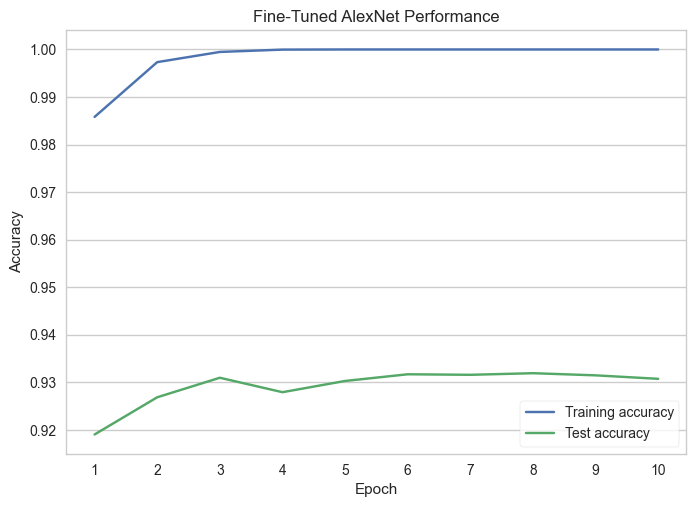

In [96]:
classifier = nn.Sequential(
  nn.Linear(OUTPUT_DIM, 256),
  nn.ReLU(),
  nn.Linear(256, 128),
  nn.ReLU(),
  nn.Linear(128, NUM_CLASSES),
)

alpha = 0.001
epochs = 10

model = AlexNet(classifier=classifier, device=device, alpha=alpha, epochs=epochs, history=True)
model.fit(train, test)

train_acc = model.record['train'][-1]
test_acc = model.record['test'][-1]

print(f'Training accuracy: {train_acc:.2%}')
print(f'Test accuracy: {test_acc:.2%}')

fig, ax = plt.subplots()

ax.plot(range(1, epochs + 1), model.record['train'], label='Training accuracy')
ax.plot(range(1, epochs + 1), model.record['test'], label='Test accuracy')

ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.grid(axis='x')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend(frameon=True)
ax.set_title("Fine-Tuned AlexNet Performance")

fig.savefig("3.8.png", dpi=600, bbox_inches='tight')

In terms of accuracy, it seems that this model is most accurate of all, having a better test performance than any MLP or CNN previously implemented. Of course, this comes at the cost of complexity, which in our case translates to compute time required for training. Simply running 10 epochs takes nearly an hour!

## 4: Originality/Creativity
An interesting thing we saw when experimenting with our first set of MLPs was that the imbalanced distribution of classes led to skewed performance in favour of the overreprested classes. To combat this, let us utilize a sort of selective data augmentation. We will over-sample the minority classes (bladder, femur, and heart) in the training set and see how it affects the performance of our best MLP, CNN, and AlexNet model. We will utilise the 128 pixel images.

In [13]:
import torchvision.transforms.v2 as TV2

In [14]:
# Loading base, un-adjusted datasets
transform = T.Compose([
  T.Lambda(AlexNet_Weights.DEFAULT.transforms()),
])

alex_train = OrganAMNIST(root='./data', split='train', transform=transform, download=True, size=128, as_rgb=True)
alex_test = OrganAMNIST(root='./data', split='test', transform=transform, download=True, size=128, as_rgb=True)

transform = T.Compose([
  T.ToTensor(),
  T.Normalize((mean_128,), (std_128,)),
])

train = OrganAMNIST(root='./data', split='train', transform=transform, download=True, size=128)
test = OrganAMNIST(root='./data', split='test', transform=transform, download=True, size=128)

Using downloaded and verified file: ./data/organamnist_128.npz
Using downloaded and verified file: ./data/organamnist_128.npz
Using downloaded and verified file: ./data/organamnist_128.npz
Using downloaded and verified file: ./data/organamnist_128.npz


In [15]:
UNDER_REPRESENTED = [0, 1, 2, 3]
AUG_SIZE = 3000

def augment(train, size: int = 128):
  AUGMENT_TRANSFORMS = T.Compose([
    TV2.RandomRotation(15),
    TV2.RandomAffine(0, translate=(0.1, 0.1)),
    TV2.RandomResizedCrop(size, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
  ])

  base = [[] for _ in range(NUM_CLASSES)]

  for item in train:
    base[item[1].item()].append(item)

  for i in UNDER_REPRESENTED:
    new = []
    for _ in range(AUG_SIZE):
      item = random.choice(base[i])
      new.append((AUGMENT_TRANSFORMS(item[0]), np.array([i])))

    base[i].extend(new)

  final = [x for c in base for x in c]
  np.random.shuffle(final)

  return final

def mlp_data():
  aug_train = augment(train)

  mlp_train = [(x.flatten(), y) for x, y in train]
  mlp_test = [(x.flatten(), y) for x, y in test]
  aug_train = [(x.flatten(), y) for x, y in aug_train]

  mlp_train_x, mlp_train_y = np.array([x for x, _ in mlp_train]), np.array([y.item() for _, y in mlp_train])
  mlp_test_x, mlp_test_y = np.array([x for x, _ in mlp_test]), np.array([y.item() for _, y in mlp_test])
  aug_mlp_train_x, aug_mlp_train_y = np.array([x for x, _ in aug_train]), np.array([y.item() for _, y in aug_train])

  del aug_train, mlp_train, mlp_test
  return mlp_train_x, mlp_train_y, mlp_test_x, mlp_test_y, aug_mlp_train_x, aug_mlp_train_y

def cnn_data():
  aug_train = augment(train)
  return train, test, aug_train

def alex_data():
  aug_train = augment(alex_train, size=224)
  return alex_train, alex_test, aug_train

In [18]:
models = [
  lambda: MultiLayerPerceptron('relu', [128 * 128, 256, 256, NUM_CLASSES], epochs=20, alpha=0.0001, l1=0.0372),
  lambda: ConvolutionalNN(nn.Sequential(nn.Conv2d(1, 8, 5, 1, 2), nn.MaxPool2d(2), nn.Conv2d(8, 16, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(4), nn.Flatten(), nn.Linear(16 * 16 * 16, 256), nn.ReLU(), nn.Linear(256, NUM_CLASSES)), device, alpha=0.005, epochs=20),
  lambda: AlexNet(nn.Sequential(nn.Linear(OUTPUT_DIM, 256), nn.ReLU(), nn.Linear(256, 128), nn.ReLU(), nn.Linear(128, NUM_CLASSES)), device, alpha=0.001, epochs=10),
]

trainers = [
  lambda m, d: m.fit(d[0], d[1]),
  lambda m, d: m.fit(d[0], d[1]),
  lambda m, d: m.fit(d[0], d[1]),
]

aug_trainers = [
  lambda m, d: m.fit(d[4], d[5]),
  lambda m, d: m.fit(d[2], d[1]),
  lambda m, d: m.fit(d[2], d[1]),
]

acc_evaluators = [
  lambda m, d: m.evaluate_acc(d[3], m.predict(d[2]))[0],
  lambda m, d: m.evaluate_acc(DataLoader(d[1], batch_size=2048)),
  lambda m, d: m.evaluate_acc(DataLoader(d[1], batch_size=2048)),
]

class_acc_evaluators = [
  lambda m, d: m.evaluate_acc(d[3], m.predict(d[2]))[1],
  lambda m, d: m.evaluate_class_acc(DataLoader(d[1], batch_size=2048)),
  lambda m, d: m.evaluate_class_acc(DataLoader(d[1], batch_size=2048)),
]

data_suppliers = [mlp_data, cnn_data, alex_data]

accs = []
results = []

for name, supplier, data_supplier, trainer, aug_trainer, evaluator, class_evaluator in zip(['MLP', 'CNN', 'AlexNet'], models, data_suppliers, trainers, aug_trainers, acc_evaluators, class_acc_evaluators):
  data = data_supplier()

  print(f"Training {name} on original dataset")
  model = supplier()
  trainer(model, data)

  acc = evaluator(model, data)
  class_acc = class_evaluator(model, data)

  accs.append((f"{name} - Base", acc))
  results.append((f"{name} - Base", class_acc))
  del model

  print(f"Training {name} on augmented dataset")
  model = supplier()
  aug_trainer(model, data)

  acc = evaluator(model, data)
  class_acc = class_evaluator(model, data)

  accs.append((f"{name} - Augmented", acc))
  results.append((f"{name} - Augmented", class_acc))

  del model
  del data

Training MLP on original dataset
Training MLP on augmented dataset
Training CNN on original dataset


Epoch 20/20: 100%|██████████| 136/136 [00:12<00:00, 10.54it/s]


Training CNN on augmented dataset


Epoch 20/20: 100%|██████████| 182/182 [00:15<00:00, 11.81it/s]


Training AlexNet on original dataset


Epoch 10/10: 100%|██████████| 136/136 [01:16<00:00,  1.78it/s]


Training AlexNet on augmented dataset


Epoch 10/10: 100%|██████████| 182/182 [02:30<00:00,  1.21it/s]


In [23]:
accuracy_df = pd.DataFrame(accs, columns=['Model', 'Accuracy'])
class_df = pd.DataFrame(zip(CLASS_LABELS, *[x[1] for x in results]), columns=['Label'] + [x[0] for x in results])

In [24]:
accuracy_df

,Model,Accuracy
0,MLP - Base,0.748003
1,MLP - Augmented,0.745528
2,CNN - Base,0.886208
3,CNN - Augmented,0.877152
4,AlexNet - Base,0.926257
5,AlexNet - Augmented,0.914276


In [26]:
class_df

,Label,MLP - Base,MLP - Augmented,CNN - Base,CNN - Augmented,AlexNet - Base,AlexNet - Augmented
0,bladder,0.673745,0.850386,0.706564,0.872587,0.837838,0.900579
1,femur-left,0.772959,0.816327,0.832908,0.929847,0.864796,0.878827
2,femur-right,0.785624,0.784363,0.929382,0.925599,0.941992,0.915511
3,heart,0.686624,0.843312,0.866242,0.915924,0.900637,0.908280
4,kidney-left,0.625484,0.529070,0.825097,0.648256,0.828488,0.733043
5,kidney-right,0.646310,0.597964,0.793384,0.779135,0.848346,0.846819
6,liver,0.896499,0.888280,0.983562,0.989954,0.993912,0.975342
7,lung-left,0.950773,0.916428,0.979966,0.995421,0.996566,1.000000
8,lung-right,0.940430,0.936018,0.972973,0.969664,0.991175,0.993381
9,pancreas,0.625154,0.635635,0.897657,0.897657,0.961159,0.955610


In [27]:
model = models[1]()
data = cnn_data()

aug_trainers[1](model, data)

Epoch 20/20: 100%|██████████| 182/182 [00:15<00:00, 12.08it/s]


In [ ]:
y_pred = []
y_true = []

for im, labels in DataLoader(data[1], batch_size=2048):
  im, labels = im.to(device), labels.to(device)

  yh = model(im)
  yh = torch.max(torch.softmax(yh, 1), 1)[1].data.cpu().numpy()
  y_pred.extend(yh)
  y_true.extend(labels.data.cpu().numpy())

<Axes: >

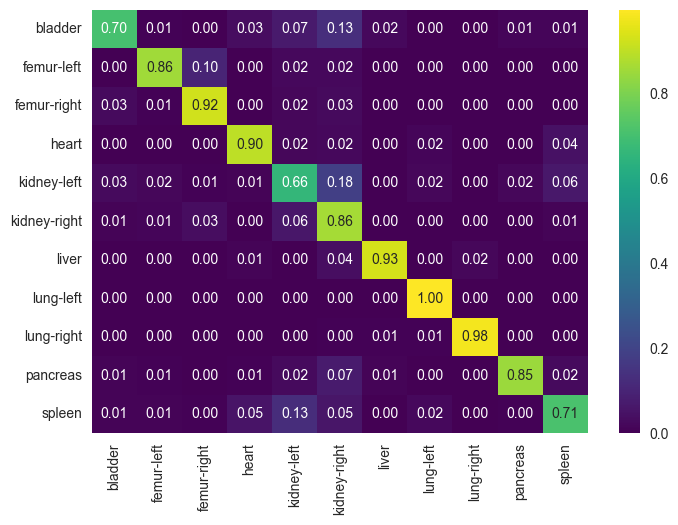

In [33]:
cf = confusion_matrix(y_true, y_pred)
cf_df = pd.DataFrame(cf / np.sum(cf, axis=1)[:, None], columns=CLASS_LABELS, index=CLASS_LABELS)

sns.heatmap(cf_df, annot=True, cmap='viridis', fmt='.2f')